# Телекоммуникации: предсказание оттока клиентов

**Описание проекта**: Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Цель исследования:** Обучить модель, которая предскажет, кто из клиентов собираются завершить контракт.

**Ход исследования**:

- Подготовка данных: загрузка данных из датасетов, изучение информации.
- Предобработка данных: проверка данных на пропуски, поиск дубликатов.
- Исследование данных: статистический анализ всех временных, числовых и категориальных признаков.
- Объединение данных: объедининение всех датасетов в один.
- Анализ признаков: анализ всех признаков в разрезе целевого, построение матрицы корреляции.
- Подготовка данных: создание пайплайнов для предобработки данных и последующего обучения моделей.
- Обучение моделей: подбор гиперпараметров, обучение моделей.
- Выбор лучшей модели: сравнение метрик качества моделей.
- Проверка качества лучшей модели: анализ качества предсказаний модели.

**Общий вывод**: Выберем лучшую модель с высокой метриков ROC-AUC.

В ходе исследования мы проанализируем признаки, влияющие на отток клиентов. Обучим несколько моделей, сравним их по метрике ROC-AUC и выберем лучшую модель.


## Загрузка и подготовка данных¶
### Загрузка данных

In [1]:
!pip install phik -q
!pip install -U scikit-learn -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
#подключим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re

# корреляции
import phik

# обучение моделей
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


# проверка качества 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve


# убираем предупреждения
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# загружаем данные

pth1 = '/datasets/contract_new.csv'
pth2 = '/datasets/personal_new.csv'
pth3 = '/datasets/internet_new.csv'
pth4 = '/datasets/phone_new.csv'

if os.path.exists(pth1):
    df_contract = pd.read_csv(pth1) # информация о договоре
else:
    print(f'Файл не найден: {pth1}')

if os.path.exists(pth2):
    df_personal = pd.read_csv(pth2) # персональные данные клиента
else:
    print(f'Файл не найден: {pth2}')

if os.path.exists(pth3):
    df_internet = pd.read_csv(pth3) # информация об интернет-услугах
else:
    print(f'Файл не найден: {pth3}')
    
if os.path.exists(pth4):
    df_phone = pd.read_csv(pth4) #информация об услугах телефонии
else:
    print(f'Файл не найден: {pth4}')

### Предобработка данных¶
- Посмотрим на основную информацию о датасетах.
- Проверим формат столбцов, количество пропусков и дубликатов.

In [4]:
# напишем метод, который будет подгружать основую информацию о датафреймах
def df_get_info(df):
    
    print('Первые 5 строк:')
    display(df.head(5))  # используем display для лучшего отображения датафрейма

    print('\n Общая информация:')
    display(df.info())

    print('\n Пропущенные значения:')
    display(df.isna().sum())
    
    print('\n Дубликаты:')
    print(df.duplicated().sum())

In [5]:
# посмотрим основную информацию о первом датасете
df_get_info(df_contract)

Первые 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



 Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


 Пропущенные значения:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


 Дубликаты:
0


**Contracts**:
- Датасет содержит заявленную информацию об абонентах: id клиента, дату начала и окончания договора, тип договора и оплаты, электронный ли расчётный лист, размер оплаты за месяц и за весь период.
- Названия столбцов необходимо заменить, сейчас формат некорректный, формат некоторых столбцов также не соответствует данным: BeginDate и EndDate можно заменить на datetime, totalcharges на float.
- Пропусков и явных дубликатов в датафрейме нет.

In [6]:
# посмотрим основную информацию о втором датасете
df_get_info(df_personal)

Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



 Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


 Пропущенные значения:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


 Дубликаты:
0


**Personal**:
- Датасет содержит заявленную информацию об абонентах: id клиента, пол клиента, является ли клиент пенсионером, есть ли у клиента супруг/супруга и дети.
- Названия столбцов необходимо заменить, сейчас формат некорректный, формат некоторых столбцов также не соответствует данным, но мы обработаем их корректным энкодером перед созданием модели.
- Пропусков и явных дубликатов в датафрейме нет.

In [7]:
# посмотрим основную информацию о третьем датасете
df_get_info(df_internet)

Первые 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



 Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


 Пропущенные значения:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


 Дубликаты:
0


**Internet**:
- Датасет содержит заявленную информацию об абонентах: id клиента, подключены ли у клиента следующие услуги: блокировка опасных сайтов, облачное хранилище файлов для резервного копирования данных, антивирус, выделенная линия технической поддержки, стриминговое телевидение, каталог фильмов.
- Названия столбцов необходимо заменить, большинство признаков бинарные, мы обработаем их корректным энкодером при создании модели.
- Пропусков и явных дубликатов в датафрейме нет.

In [8]:
# посмотрим основную информацию о четвёртом датасете
df_get_info(df_phone)

Первые 5 строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



 Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


 Пропущенные значения:


customerID       0
MultipleLines    0
dtype: int64


 Дубликаты:
0


**Phone**:
- Датасет содержит заявленную информацию об абонентах: id клиента и есть ли у клиента услуга подключения к нескольким линиям.
- Названия столбцов необходимо заменить, сейчас формат некорректный.
- Пропусков и явных дубликатов в датафрейме нет.

### Вывод по разделу:
- Мы загрузили четыре датафрейма с данными о клиентах, в датасетах содержится информация о клиентах, типах подключения, услугах и оплате. Все заявленые данные в датасетах присутствуют. 
- Названия всех столбцов необходимо заменить для более удобной работы, также формат некоторых столбцов не соответствует данным, заменим его.
- Пропусков и явных дубликатов в датафреймах не обнаружено.

## Исследовательский анализ данных
- Проведем исследовательский анализ данных каждого датафрейма.
- Построим графики для временных, числовых и категориальных признаков.
- Объединим все признаки в один датафрейм.
- Проведем анализ признаков в разрезе целевого признака
- Проверим корреляции

### Contract

In [9]:
# сначала переименуем все столбцы, будем использовать регулярные выражения
df_contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df_contract.columns]

# отдельно переименуем столбце с id
df_contract = df_contract.rename(columns={'customer_i_d':'customer_id'})

# проверим
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [10]:
# поменяем формат столбцов
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])

In [11]:
# поменяем формат окончания договора, но этот столбец важен нам ещё и как целевой признак
# сделаем из него новый бинарный столбец
df_contract['end_date_target'] = df_contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

# сначала заменим 'No' на 01.02.2020 - дату выгрузки данных, чтобы корректно поменять формат данных
df_contract['end_date'] = df_contract['end_date'].replace('No', '2020-02-01')

# теперь преобразуем столбец с датой окончания договора в datetime
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')

#поменяем формат столбца с числовыми данными на float
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

In [12]:
# проверим
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   end_date_target    7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


In [13]:
# проверим не появилось ли новых пропусков после преобразований
df_contract.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
end_date_target       0
dtype: int64

После преобразования данных появились пропуски в total_charges. Надо рассмотреть эти данные подробнее.

In [14]:
tcharges_na = df_contract.query("total_charges.isnull()")
tcharges_na

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


У рассмотренных клиентов совпадают begin_date и end_date, то есть она начали пользоваться услугами сервиса в день выгрузки данных. Скорее всего данные об общей сумме оплаты ещё не успели сформироваться, хотя у них есть сумма ежемесячного платежа. Суммарный платёж точно не может быть меньше этой суммы, поэтому заменим total на monthly. 

In [15]:
# заменим на значения суммы за месяц
df_contract.loc[df_contract['total_charges'].isna(), 'total_charges'] = df_contract['monthly_charges']

# проверим
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
end_date_target      0
dtype: int64

Посмотрим на данные, построим графики.

In [16]:
# сначала построим графики частоты начала контрактов в разрезе по месяцам
# группируем данные по месяцам, сортируем по времени
begin_months = df_contract['begin_date'].dt.to_period('M').value_counts().sort_index()

# переформирум индексы в datetime для построения графиков
begin_months.index = begin_months.index.to_timestamp()

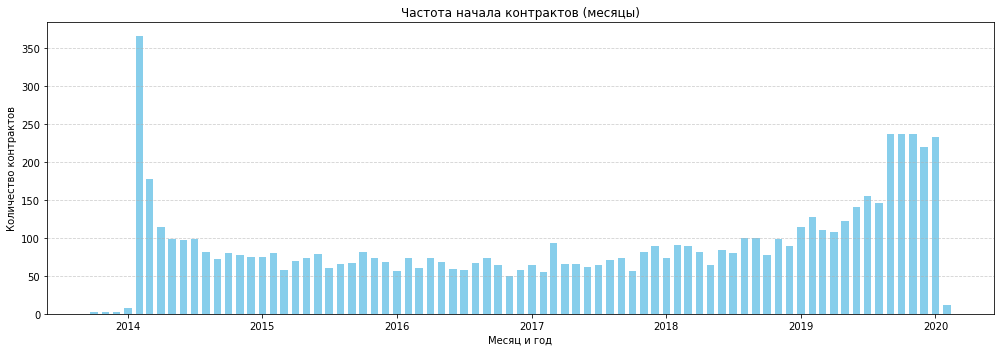

In [17]:
# построим график с частотой старта контрактов
plt.figure(figsize=(14, 5))
plt.bar(begin_months.index, begin_months.values, width=20, color='skyblue')
plt.title('Частота начала контрактов (месяцы)')
plt.xlabel('Месяц и год')
plt.ylabel('Количество контрактов')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Пик в начале графика в 2014 году, скорее всего большинство существующих контрактов было внесено в данные в этот период, либо в этот период стартовала работа сервиса. Далее данные распределены равномерно до 2018 года, с 2018 года наблюдается плавный рост.
- Пик роста приходится на конец 2019 года, количество контрактов достигает примерно 250 в месяц.

In [18]:
# создадим дополнительные признаки, которые могут быть полезны для обучения модели: месяц старта контракта, год старта
df_contract['begin_month'] = df_contract['begin_date'].dt.month
df_contract['begin_year'] = df_contract['begin_date'].dt.year

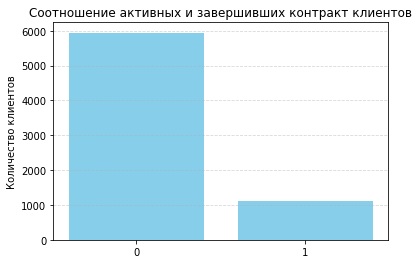

In [19]:
# проверим соотношение активных клиетнов и клиентов, которые прервали контракт
clients_segment = df_contract['end_date_target'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(clients_segment.index.astype(str), clients_segment.values, color='skyblue')
plt.title('Соотношение активных и завершивших контракт клиентов')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [20]:
# посчитаем процент каждого сегмента
clients_segment_percent = df_contract['end_date_target'].value_counts(normalize=True) * 100
clients_segment_percent = clients_segment_percent.round(2)

clients_segment_percent

0    84.37
1    15.63
Name: end_date_target, dtype: float64

По этому графику видим, что у нас есть дисбаланс классов целевого признака, поэтому будем использовать стратификацию при подготовке данных для модели.

Посмотрим на данные по окончанию контрактов.

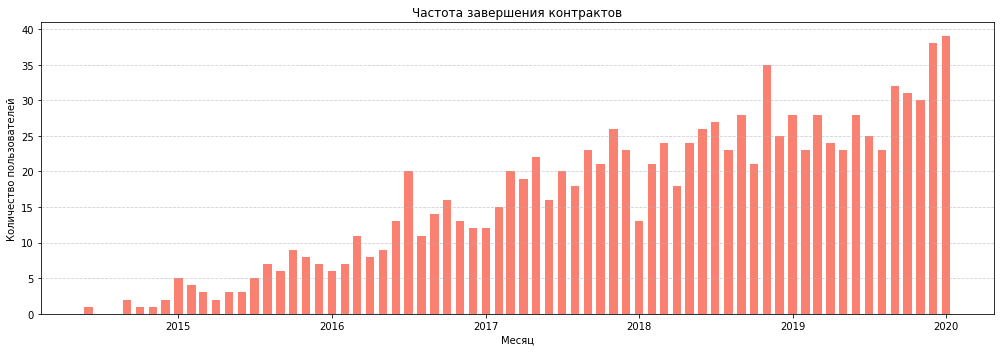

In [21]:
# для анализа данных по завершению контрактов отберем только тех, кто завершил контракт
ended_df = df_contract.query("end_date_target == 1")

# группируем по месяцам
ended_by_month = ended_df['end_date'].dt.to_period('M').value_counts().sort_index()
ended_by_month.index = ended_by_month.index.to_timestamp()

# построим график
plt.figure(figsize=(14, 5))
plt.bar(ended_by_month.index, ended_by_month.values, width=20, color='salmon')
plt.title('Частота завершения контрактов')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Отток клиентов растет с 2015 по 2020, количество завершённых контрактов постепенно увеличивается почти каждый год. Рост может быть связан с ростом количества клиентов.
- Пик в почти конце 2019 года, он может быть связан с изменениями в тарифах или услугах.
- Регулярная сезонность отсутствует, нет чётких спадов или подъёмов по сезонам.

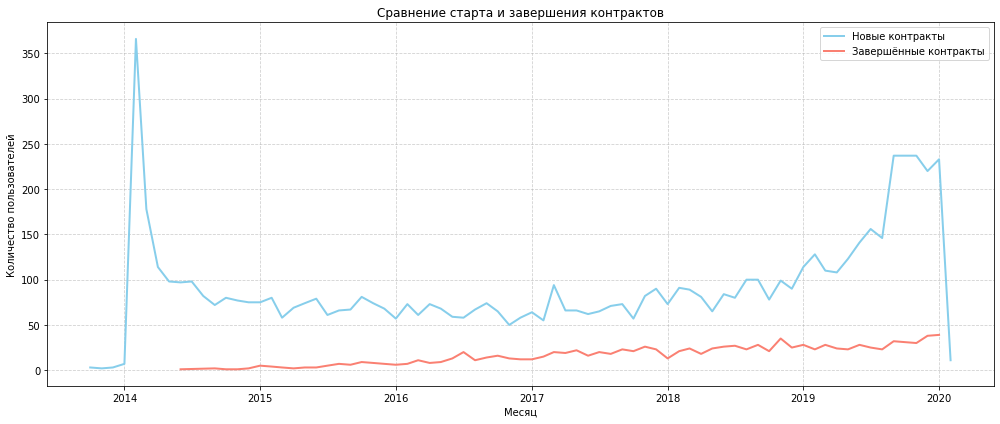

In [22]:
# наложим графики друг на друга, сравним заключение новых контрактов и завершение

plt.figure(figsize=(14, 6))

# График начала контрактов (приток)
plt.plot(begin_months.index, begin_months.values, label='Новые контракты', color='skyblue', linewidth=2)

# График завершения контрактов (отток)
plt.plot(ended_by_month.index, ended_by_month.values, label='Завершённые контракты', color='salmon', linewidth=2)

plt.title('Сравнение старта и завершения контрактов')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


- Отток клиентов растёт, но сильно отстаёт от заключения новых контрактов.
- Ближе к 2020 разница между новыми и завершёнными контрактами уменьшается.

На основе существующих дат добавим новый признак - длительность контракта.

In [23]:
# добавим признак длительность контракта
df_contract['contract_days'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

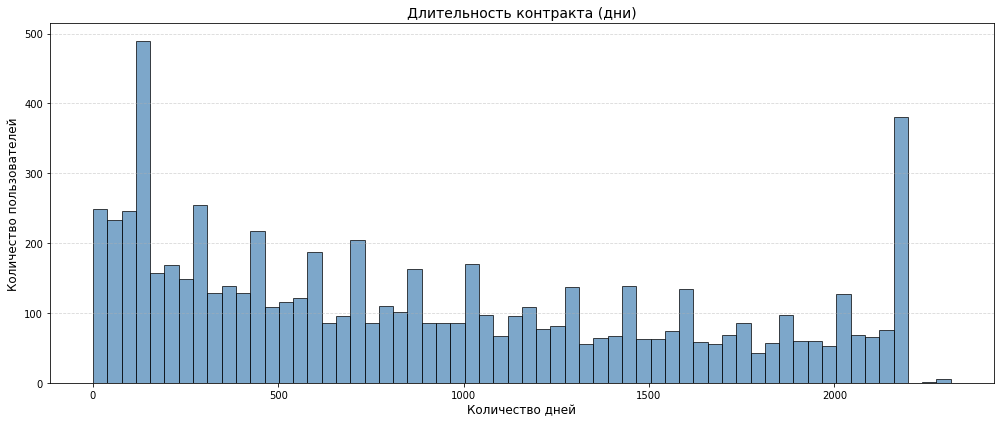

In [24]:
# посмотрим как распределены данные
plt.figure(figsize=(14, 6))
plt.hist(df_contract['contract_days'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)

plt.title('Длительность контракта (дни)', fontsize=14)
plt.xlabel('Количество дней', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Пик на отметке около 200 дней - здесь могут быть, как новые клиенты, рост, которых наблюдается в последние месяцы, так и клиенты, которые отказались от услуг в первые месяцы использования. 
- Значительная часть контрактов не превышает 1200 дней.
- Пик в конце графика (примерно 2200 дней) - долгоживущие клиенты.

Проанализируем распределение числовых признаков.

In [25]:
# посмотрим на распределение ежемесячных расходов
df_contract['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

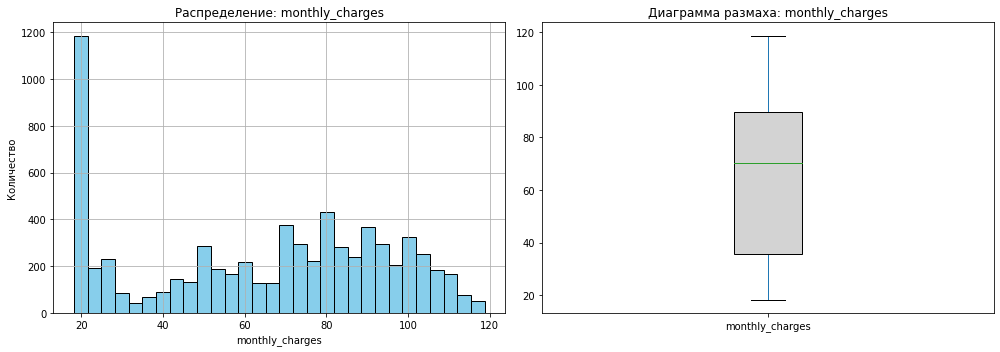

In [26]:
# построим гистограмму и диаграмму размаха
# сделаем метод, который строит сразу два нужных графика для численных признаков

def plot_hist_and_box(df, column, bins=30):

    plt.figure(figsize=(14, 5))

    # строим гистограмму
    plt.subplot(1, 2, 1)
    df[column].hist(bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Распределение: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')

    # строим диаграмму размаха
    plt.subplot(1, 2, 2)
    df[column].plot(kind='box', vert=True, patch_artist=True,
                             boxprops=dict(facecolor='lightgray'))
    plt.title(f'Диаграмма размаха: {column}')

    plt.tight_layout()
    plt.show()

plot_hist_and_box(df_contract, 'monthly_charges')

**Гистограмма**:
- Ежемесячные расходы варьируются от 20 до 120.
- Пик в начале гистограммы - большая часть клиентов пользуется самы базовым тарифом с минимальной ежемесячной оплатой.
- Следующий пик на значении 80 - тоже популярный ежемесячный тариф.

**Диаграмма размаха**:
- Медиана примерно 70. 
- Межквартильный размах - от 35 до 90.
- Минимальные и максимальные значения от 20 до 120, выбросов нет.

In [27]:
# посмотрим на распределение общих расходов
df_contract['total_charges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

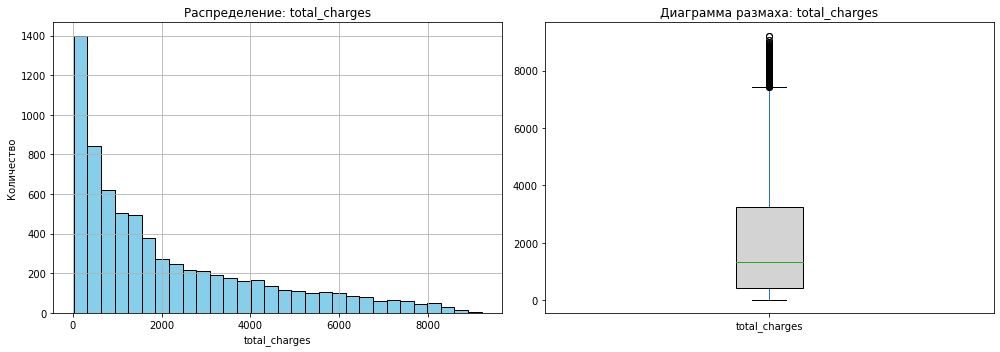

In [28]:
# построим диаграммы для общих платежей
plot_hist_and_box(df_contract, 'total_charges')

**Гистограмма**:
- Распределение сильно асимметрично, основная масса пользователей суммарно заплатила до 2000.
- Резкий пик на минимальных суммах ниже 500. Возможно, это новые клиенты с минимальными тарифами, либо клиенты, которые быстро перестали пользоваться услугами.

**Диаграмма размаха**:
- Медиана примерно 1500. 
- Межквартильный размах - от 700 до 2500.
- Множество выбросов - зто клиенты, которые суммарно заплатили больше 7500.


In [29]:
# сделаем метод для анализа категориальных признаков, который строит по 2 диаграммы на строку
def plot_category_pie(df, columns):
    n = len(columns)
    rows = math.ceil(n / 2)
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        counts = df[col].value_counts()
        axes[i].pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140)
        axes[i].set_title(f'{col}', fontsize=14)

    # удаляем лишние оси для нечетного количества признаков
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Распределения по категориям', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

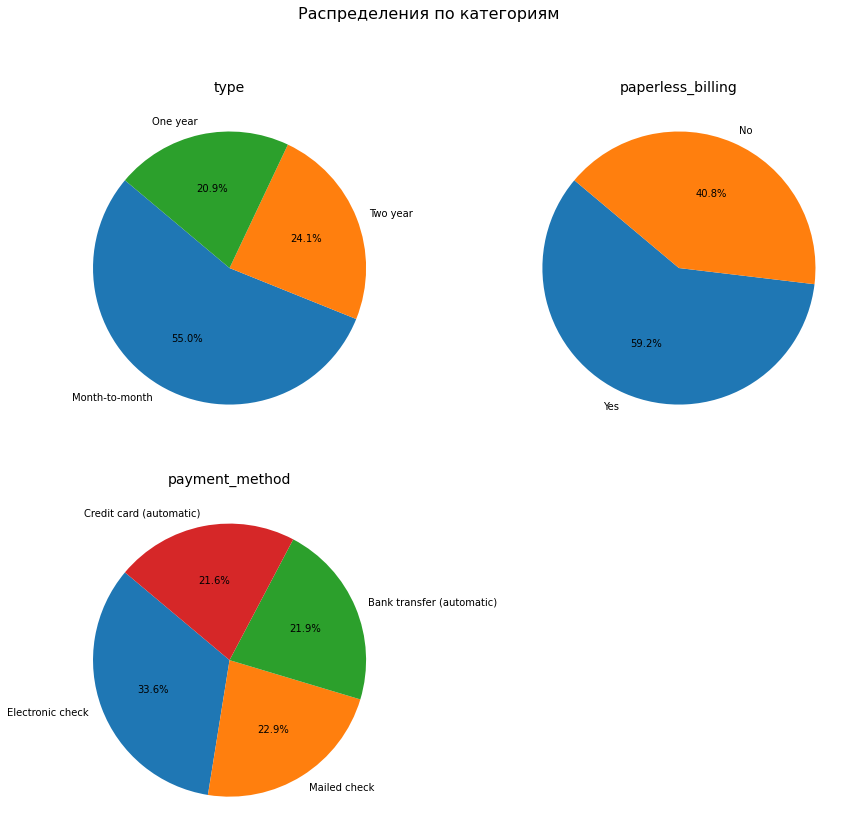

In [30]:
# Список интересующих категориальных столбцов
columns_pie = ['type', 'paperless_billing', 'payment_method']

# Или pie-графики
plot_category_pie(df_contract, columns_pie)


- **Тип подключения** - всего три типа подключения: 55% клиентов подключены с ежемесячной оплатой, 24% клиентов оплатили два года, 21% - один год.
- **Электронный расчётный лист** - 59% пользователей имеют электронный расчётный лист, 41% - не имеют.
- **Тип платежа** - 34% клиентов оплачивают услуги по электронному чеку (онлайн платёж), 23% с отправкой чека обычной почтой, 22% через банковский перевод, 22% авто-платежи банковской картой.

### Personal

- Посмотрим данные о клиентах, построим графики для категориальных признаков.

In [31]:
# проверим общую информацию
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [32]:
# сначала переименуем все столбцы
df_personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df_personal.columns]
df_personal = df_personal.rename(columns={'customer_i_d':'customer_id'})

# проверим
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

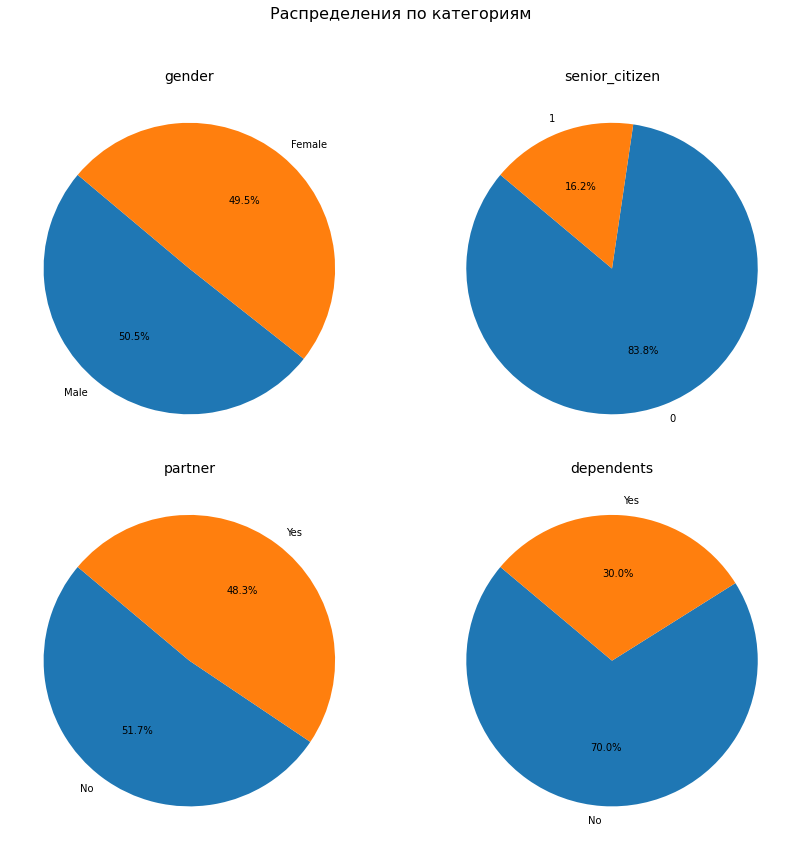

In [33]:
# сделаем список столбцов для метода
columns_pie = ['gender', 'senior_citizen', 'partner', 'dependents']

# построим графики
plot_category_pie(df_personal, columns_pie)

Посмотрим на распределение признаков по категориям: 
- **Пол**: распределение примрно по 50%. 
- **Сведения о пенсионном статусе** - 16% пользователей являются пенсионерами, 84% - не являются.
- **Партнёр** - 48% клиентов имеют супруга/супругу, 52% - не имеют.
- **Дети** - у 30% клиентов есть дети, у - 70% детей нет.
- Каких либо отклонений в данных, дополнительных категорий или аномалий нет.

### Internet

- Посмотрим информацию о подключенных услугах.

In [34]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [35]:
# переименуем столбцы
df_internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df_internet.columns]
df_internet = df_internet.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'})

# проверим
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

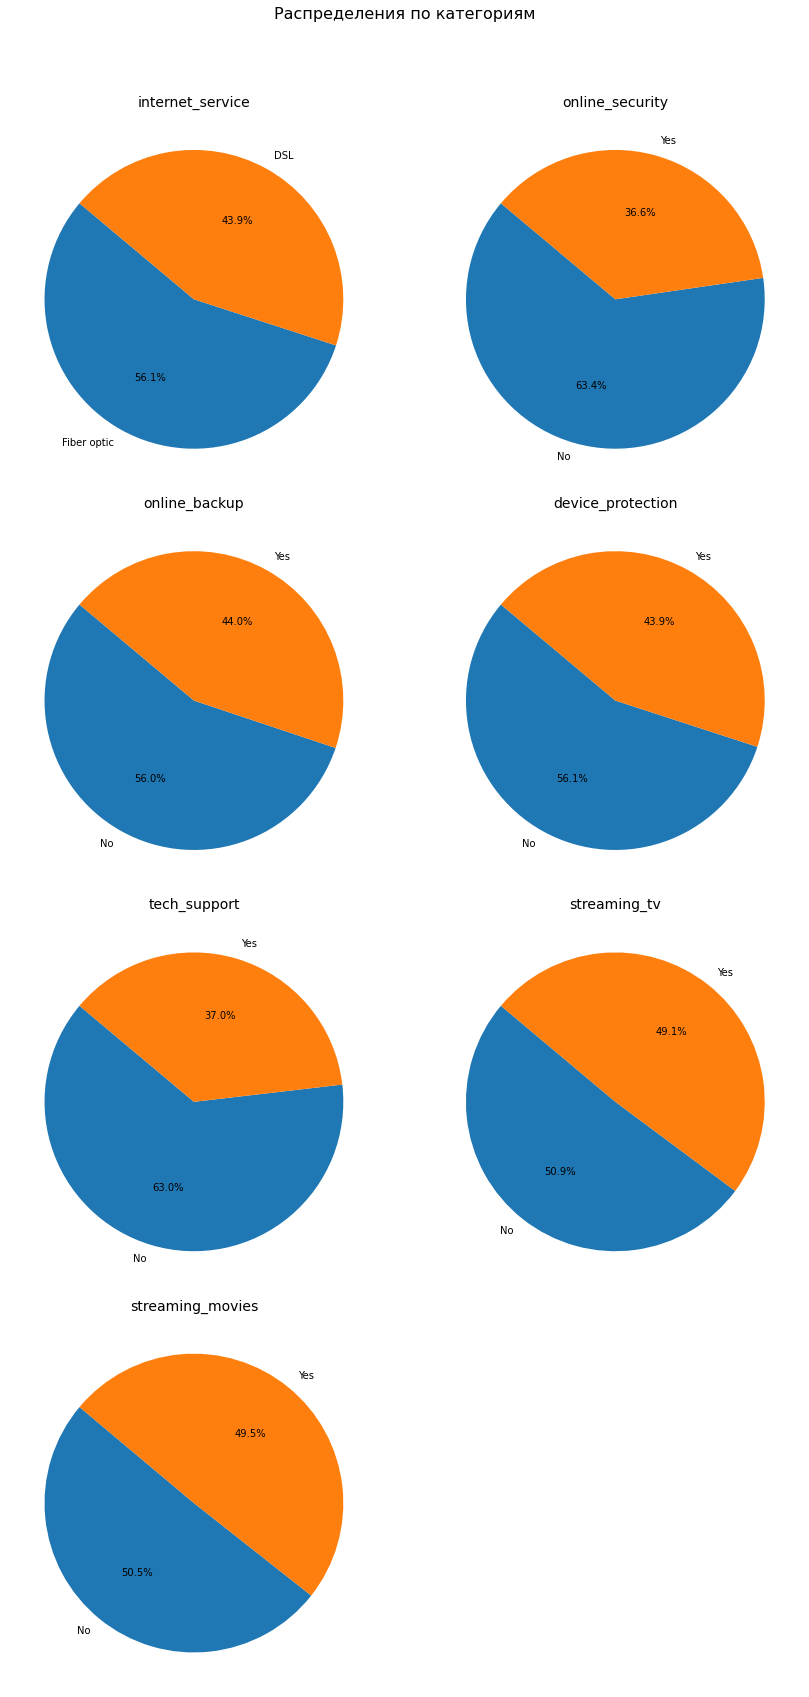

In [36]:
# сделаем новый список категориальных столбцов
columns_pie = ['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# построим графики
plot_category_pie(df_internet, columns_pie)

- **Тип подключения** - 56% клиентов использут оптоволокно, 44% DSL. 
- **Блокировка опасных сайтов** -63% не использут, 37% используют блокировку. 
- **Облачное хранилище** - 56% не используют, 44% используют.
- **Антивирус** - 56% не используют антивирус, 44% используют.
- **Выделенная линия тех.поддержки** - 63% клиентов не используют, 37 используют. 
- **Стриминговое телевидение и фильмы** - половина клиентов использует сервисы видео.

- Аномалий в данных или дополнительных категорий, некорректных названий в данных нет.

### Phone
- Посмотрим сколько кликнтов используют несколько линий для подключения телефона.

In [37]:
# переименуем два признака
df_phone = df_phone.rename(columns={'customerID':'customer_id', 'MultipleLines':'multiple_lines'})

# проверим
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

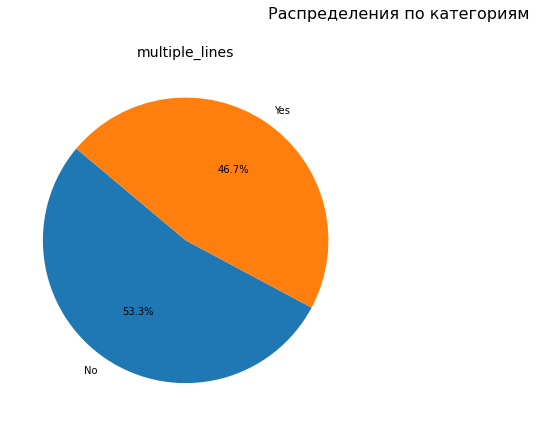

In [38]:
# добавим в список только один столбец
columns_pie = ['multiple_lines']

# Или pie-графики
plot_category_pie(df_phone, columns_pie)

- **Дополнительный телефонные линии** - 53% клиентов не используют, 47 используют.

### Выводы по разделу: 
- Мы проанализировали все данные в датафреймах.
- Изменили формат признаков 'begin_date' и 'end_date' на datetime, заменили значения 'No' в признаке 'end_date' на дату выгрузки данных.
- Добавили целевой признак 'end_date_target', где 0 - активные пользователи, 1 - пользователи, которые завершили контракт. 
- Заменили формат числового признака 'total_charges', после смены формата обнаружили 11 пропусков у новых пользователей, которые заменили на значение месячного платежа этих пользователей.
- Посчитали соотношение активных пользователей и пользователей, которые завершили контракт: 84 - активные, 16% - завершили контракт. Есть дисбаланс классов целевого признака, поэтому будем использовать стратификацию при подготовке данных для модели.
- Построили временные графики для отслеживания периода старта контрактов: пик в начале графика в 2014 году, скорее всего большинство существующих контрактов было внесено в данные в этот период, либо в этот период стартовала работа сервиса. Далее данные распределены равномерно до 2018 года, с 2018 года наблюдается плавный рост. Пик роста приходится на конец 2019 года, количество контрактов достигает примерно 250 в месяц.
- Построили график по оттоку клиентов: отток клиентов растет с 2015 по 2020, количество завершённых контрактов постепенно увеличивается почти каждый год. Рост может быть связан с ростом количества клиентов. Пик почти в конце 2019 года, он может быть связан с изменениями в тарифах или услугах. Регулярная сезонность отсутствует, нет чётких спадов или подъёмов по сезонам.
- Сравнили старт контрактов и отток клиентов: с 2014 года отток клиентов растёт, но сильно отстаёт от заключения новых контрактов. Ближе к 2020 разница между новыми и завершёнными контрактами уменьшается.
- Добавили новый признак - длительность контракта в днях. Построили распределение: пик на отметке около 200 дней - здесь могут быть, как новые клиенты, рост, которых наблюдается в последние месяцы, так и клиенты, которые отказались от услуг в первые месяцы использования. Значительная часть контрактов не превышает 1200 дней. Пик в конце графика (примерно 2200 дней) - долгоживущие клиенты.
- **Ежемесячные расходы** варьируются от 20 до 120. Пик в начале гистограммы - большая часть клиентов пользуется самы базовым тарифом с минимальной ежемесячной оплатой. Следующий пик на значении 80 - тоже популярный ежемесячный тариф. Медиана примерно 70, межквартильный размах - от 35 до 90, минимальные и максимальные значения от 20 до 120, выбросов нет.
- **Суммарные расходы** - распределение сильно асимметрично, основная масса пользователей суммарно заплатила до 2000. Резкий пик на минимальных суммах ниже 500. Возможно, это новые клиенты с минимальными тарифами, либо клиенты, которые быстро перестали пользоваться услугами. Медиана примерно 1500, межквартильный размах - от 700 до 2500. Множество выбросов - зто клиенты, которые суммарно заплатили больше 7500.
- Категориалиные признаки: **Тип подключения** - всего три типа подключения: 55% клиентов подключены с ежемесячной оплатой, 24% клиентов оплатили два года, 21% - один год. **Электронный расчётный лист** - 59% пользователей имеют электронный расчётный лист, 41% - не имеют. **Тип платежа** - 34% клиентов оплачивают услуги по электронному чеку (онлайн платёж), 23% с отправкой чека обычной почтой, 22% через банковский перевод, 22% авто-платежи банковской картой.
- **Персональные данные клиентов** - **Пол**: распределение примрно по 50%. **Сведения о пенсионном статусе** - 16% пользователей являются пенсионерами, 84% - не являются. **Партнёр** - 48% клиентов имеют супруга/супругу, 52% - не имеют. **Дети** - у 30% клиентов есть дети, у - 70% детей нет.
- **Интернет подключение и телефония** - **тип подключения** - 56% клиентов использут оптоволокно, 44% DSL. **Блокировка опасных сайтов** -63% не использут, 37% используют блокировку. **Облачное хранилище** - 56% не используют, 44% используют. **Антивирус** - 56% не используют антивирус, 44% используют. **Выделенная линия тех.поддержки** - 63% клиентов не используют, 37 используют. **Стриминговое телевидение и фильмы** - половина клиентов использует сервисы видео. - **Дополнительный телефонные линии** - 53% клиентов не используют, 47 используют.
- Каких либо отклонений в данных, дополнительных категорий или аномалий не обнаружено.



## Объединение данных и анализ признаков

- Объединим все данные на основе id
- Проведем анализ данных в разрезе по категориям пользователей

### Объединение данных

In [39]:
# проверим размерность всех датафреймов 
df_contract.shape, df_personal.shape, df_internet.shape, df_phone.shape

((7043, 12), (7043, 5), (5517, 8), (6361, 2))

У датафреймов разное количество строк, попробуем объединить их на основе id первого датафрейма, а затем проврерим пропуски.

In [40]:
# объединим таблицы методом merge на основе id
df_full = df_contract.merge(df_personal, on='customer_id', how='left')
df_full = df_full.merge(df_internet, on='customer_id', how='left')
df_full = df_full.merge(df_phone, on='customer_id', how='left')
df_full.shape

(7043, 24)

In [41]:
# посмотрим, что получилось
df_get_info(df_full)

Первые 5 строк:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_date_target,begin_month,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,1,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,4,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,10,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,5,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,9,...,No,No,Fiber optic,No,No,No,No,No,No,No



 Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   end_date_target    7043 non-null   int64         
 9   begin_month        7043 non-null   int64         
 10  begin_year         7043 non-null   int64         
 11  contract_days      7043 non-null   int64         
 12  gender             7043 non-null   object        
 13  senior_citizen     7043 non-null   int64   

None


 Пропущенные значения:


customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
end_date_target         0
begin_month             0
begin_year              0
contract_days           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


 Дубликаты:
0


- После объединения датафреймов появились пропуски в данных.
- В основном пропуски появились в признаках датафрейма с информацией об интернет-услугах и телефонии. Так как мы объединяли данные на основе id клиентов, то пропуски образовались в тех услугах, которыми клиент не пользуется. Мы заменим эти пропуски на 'not_used'.

In [42]:
# подготовим список столбцов с пропусками
cols_na = [
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines'
]

# заполним пропуски значением 'not_used'
df_full[cols_na] = df_full[cols_na].fillna('not_used')

# проверяем
df_full.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
end_date_target      0
begin_month          0
begin_year           0
contract_days        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [43]:
# проверим есть ли в данных неявные пропуски
hided_na = ['', ' ', 'n/a', 'na', '-', 'NAN', 'none', 'null', 'missing', 'нет', 'unknown']

for col in df_full.select_dtypes(include='object'):
    mask = df_full[col].str.strip().str.lower().isin(hided_na)
    print(f'{col}: {mask.sum()} пропусков')

customer_id: 0 пропусков
type: 0 пропусков
paperless_billing: 0 пропусков
payment_method: 0 пропусков
gender: 0 пропусков
partner: 0 пропусков
dependents: 0 пропусков
internet_service: 0 пропусков
online_security: 0 пропусков
online_backup: 0 пропусков
device_protection: 0 пропусков
tech_support: 0 пропусков
streaming_tv: 0 пропусков
streaming_movies: 0 пропусков
multiple_lines: 0 пропусков


### Анализ признаков в разрезе целевого
- Подготовим два датафрейма: с активными клиентами и клиентами, которые завершили контракт 
- Построим графики для сравнения основных признаков
- Опишем портрет пользователя, который ушел


In [44]:
# разделим пользователей на группы
df_active = df_full[df_full['end_date_target'] == 0] # активные пользователи
df_churned = df_full[df_full['end_date_target'] == 1] # пользователи, которые завершили контракт

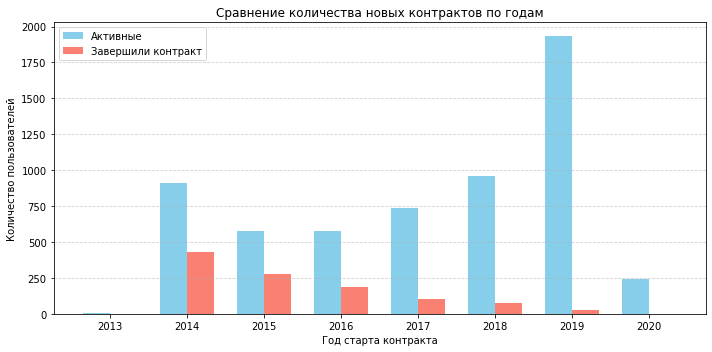

In [45]:
# построим столбчатую диаграмму для сравнения групп пользователей по годам старта контракта
active_years = df_active['begin_year'].value_counts().sort_index()
ended_years = df_churned['begin_year'].value_counts().sort_index()

# объединм в общий
all_years = sorted(set(active_years.index).union(ended_years.index))
active_years = active_years.reindex(all_years, fill_value=0)
ended_years = ended_years.reindex(all_years, fill_value=0)
x = np.arange(len(all_years))
width = 0.35


# построим график
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, active_years.values, width=width, label='Активные', color='skyblue')
plt.bar(x + width/2, ended_years.values, width=width, label='Завершили контракт', color='salmon')

plt.xticks(x, all_years)
plt.xlabel('Год старта контракта')
plt.ylabel('Количество пользователей')
plt.title('Сравнение количества новых контрактов по годам')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Завершившие контракт пользователи чаще всего заключали контракт в 2014 году. Далее по графику плавные спад по ушедшим пользователям.
- Пик активных пользователей в был 2019 году.

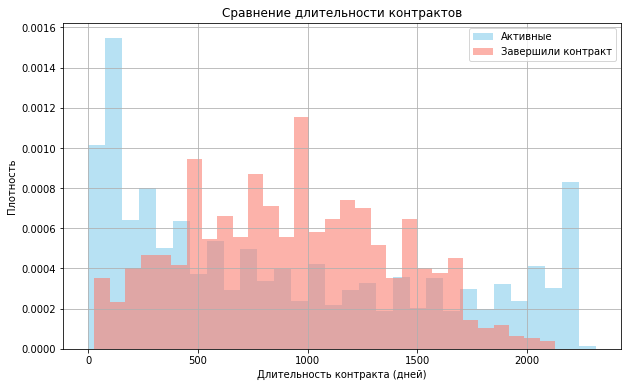

In [46]:
# построим диаграмму для сравнения длительности контрактов
plt.figure(figsize=(10, 6))

plt.hist(df_active['contract_days'], bins=30, alpha=0.6, label='Активные', color='skyblue', density=True)
plt.hist(df_churned['contract_days'], bins=30, alpha=0.6, label='Завершили контракт', color='salmon', density=True)

plt.title('Сравнение длительности контрактов')
plt.xlabel('Длительность контракта (дней)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_num_feature(df_active, df_churned, feature, bins: int = 30):

    # подготовим признаки
    df1 = df_active[[feature]].copy()
    df1['status'] = 'Активные'

    df2 = df_churned[[feature]].copy()
    df2['status'] = 'Завершили контракт'
    
    # соберем данные в один датафрейм
    df_combined = pd.concat([df1, df2], ignore_index=True)

    # построим гистограмму
    plt.figure(figsize=(10, 5))
    plt.hist(df_active[feature], bins=bins, alpha=0.6, label='Активные', color='skyblue', density=True)
    plt.hist(df_churned[feature], bins=bins, alpha=0.6, label='Завершили контракт', color='salmon', density=True)
    plt.title(f'Гистограмма признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # построим диаграмму размаха
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df_combined, x='status', y=feature, palette=['skyblue', 'salmon'])
    plt.title(f'Boxplot признака: {feature}')
    plt.xlabel('')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


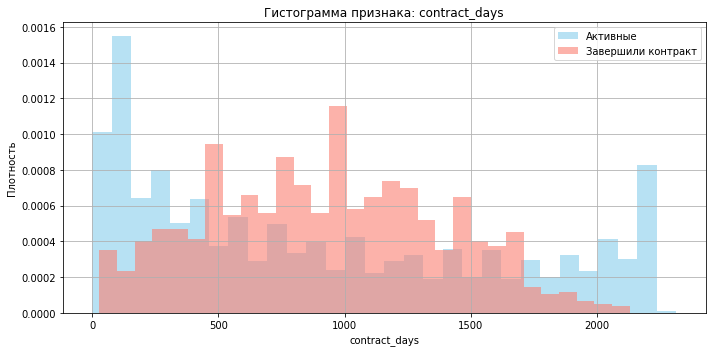

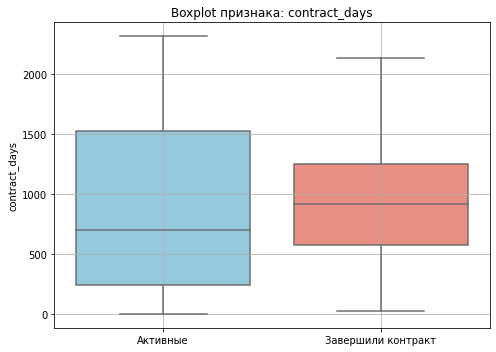

In [48]:
# построим диаграммы для сравнения признаков
compare_num_feature(df_active, df_churned, 'contract_days')

**Гистограмма**
- Активные пользователи в основном сконцентрированы в началае диаграммы, то есть контракт не превышает 200 дней - это новые пользователи, подъем которых мы наблюдали с 2019 года. Также пик активных пользователей есть на отметке более 2000 дней, то есть максимум по нашим данным - пользователи, которые пришли в самом начале и до сих пор пользуются услугами.
- Ушедшие пользователи - пики примерно по 500 и 1000 дней, после 1000 дней идёт спад. 
- Активные пользователи чаще имеют длительные контракты, в то время как среди завершивших больше тех, кто завершил в течение среднего срока от 1 до 3 лет.

**Диаграмма размаха**
- Активные пользователи - медиана около 750 дней, общий диапазон от 0 до 2200 дней, основная плотность - 250 - 1500 дней.
- Ушедшие пользователи - медиана выше, примерно 900 дней, основная плотность пользователей от 550 до 1200 дней, диапазон от 10 до 2100 дней.
- У активных пользователей более широкий разброс длительности контрактов. Медиана у завершивших чуть выше, но распределение менее растянуто, чем у активных.

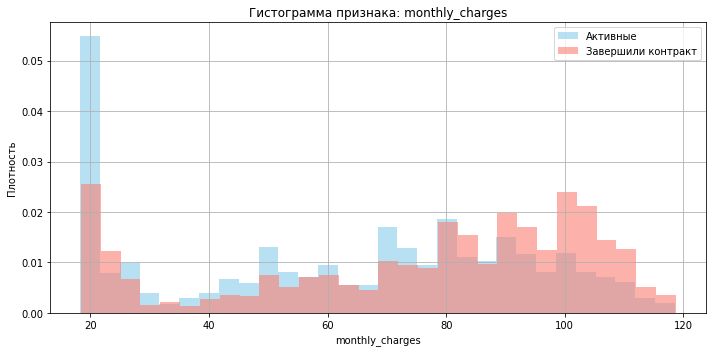

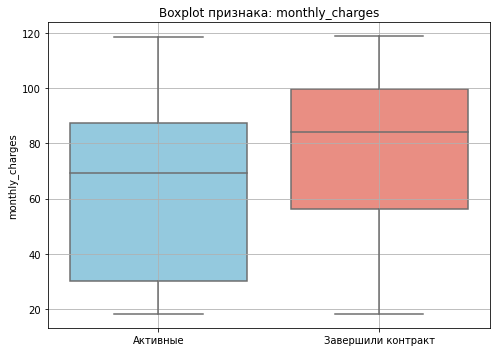

In [49]:
# посмотрим на числовой признак 'ежемесячный платёж'
compare_num_feature(df_active, df_churned, 'monthly_charges')

**Гистограмма**
- Активные пользователи - явно выраженный пик 20–25 - самый базовый тариф, далее значения плотности снижаются, небольшой пик на 70, больше 100 платят немного пользователей.
- Завершившие контракт - в два раза меньше пользователей с минимальными платежами, пик плотности на 100, Значительно больше пользователей с высокими ежемесячными платежами более 100.

**Диаграмма размаха**
- Активные пользователи: медиана около 70, межквартильный размах (IQR) — от 30 до 90. Распределение смещено к нижним значениям, то есть много пользователей с относительно низкими платежами.
- Завершившие контракт: Медиана выше - около 90, межквартильный размах — от 55 до 100. Распределение смещено к высоким значениям, то есть большинство клиентов, которые ушли, платили больше.



- **Высокие платежи чаще связаны с оттоком пользователей**. Возможно им не требуются все услуги за которые они платят, то есть некорректно подобраный для них тариф. Эта категория пользователей важна, поэтому необходимо чаще проверять пользуются ли они всеми услугами, напоминать о преимуществах их тарифов, уведомлять об альтернативных тарифах.


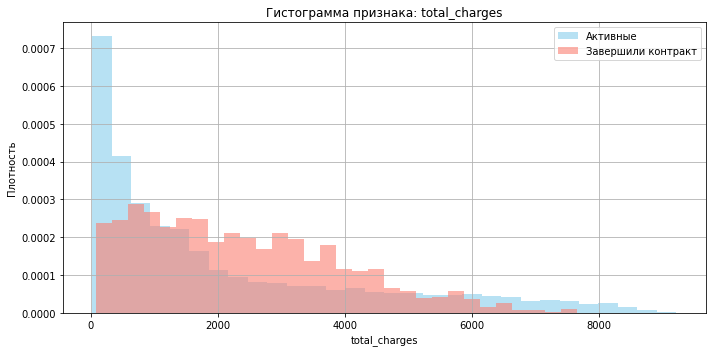

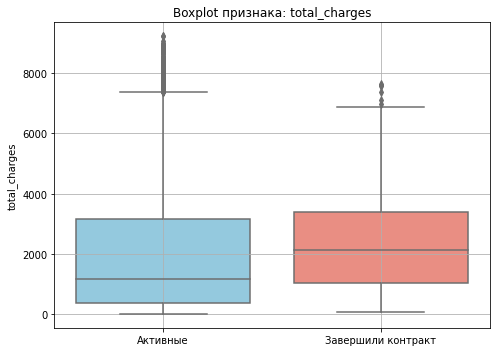

In [50]:
# посмотрим на числовой признак 'суммарный платёж'
compare_num_feature(df_active, df_churned, 'total_charges')

**Гистограмма**
- Активные пользователи: пик плотности от 0 до 500, похоже на клиентов, которые недавно подключились. Плотность резко спадает после 1000, низкие значения после 2000. Хвост распределения длинный, но низкий: немного пользователей с суммой выше 4000.
- Завершившие контракт: плотность равномерно распределени 0 10 до 4000 с плавным небольшим спадом. Постепенный спад после 4000, но плотность остаётся выше, чем у активных.

**Диаграмма размаха**
- Активные: медиана около 1000, нижняя граница межквартильного размаха ближе к нулю. Много выбросов более 7000. 
- Завершившие контракт: медиана 2000, нижняя граница межквартильного размаха выше, чем у активных, а верхняя почти совпадает. Выбросов меньше, они не превышают 8000. 

- У активных пользователей общая сумма платежей значительно ниже, так как многие подключились недавно и пользуются базовым тарифом. Ушедшие пользователи чаще имеют средний или высокий общий платёж и они уходят после длительного периода использования. Этот признак тоже связан с оттоком. Разделим пользоваталей на сегменты и проверим в каком сегменте отток больше. 

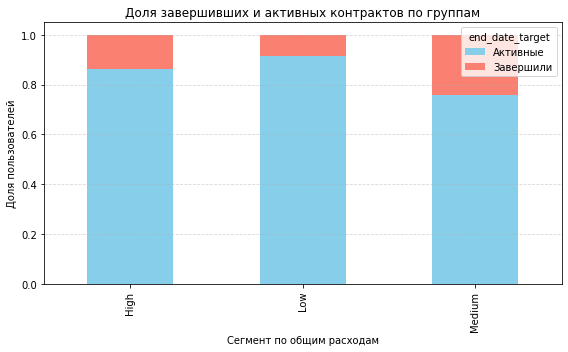

In [51]:
# сгруппируем пользователей по сумме расходов, сделаем три основные группы
def assign_spending_group(charge):
    if charge < 1000:
        return 'Low'
    elif charge < 4000:
        return 'Medium'
    else:
        return 'High'

# добавим новый признак
df_full['spending_group'] = df_full['total_charges'].apply(assign_spending_group)

# сгруппируем сколько пользователей ушло и осталось
contracts_by_group = df_full.groupby('spending_group')['end_date_target'].value_counts(normalize=True).unstack()

# построим столбчатые диаграммы
contracts_by_group.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], figsize=(8, 5))
plt.title('Доля завершивших и активных контрактов по группам')
plt.xlabel('Сегмент по общим расходам')
plt.ylabel('Доля пользователей')
plt.legend(['Активные', 'Завершили'], title='end_date_target')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Наибольшая доля клиентов, завершивших контракт среди среднего сегмента по сумме расходов. 
- Меньше всего клиентов завершивших контракт среди группы с низкими расходами.

In [52]:
# посчитаем медианные значения для числовых признаков
num_features = ['contract_days', 'monthly_charges','total_charges']

# группируем по статусу и считаем медиану
summary_table = df_full.groupby('end_date_target').agg(
    {col: 'median' for col in num_features})

# транспонируем для удобства просмотра
summary_table.T

end_date_target,0,1
contract_days,702.0,915.00
monthly_charges,69.2,84.20
total_charges,1192.8,2139.03


Посчитаем медианные значения числовых признаков для каждой группы:
- Ушедшие пользователи в среднем имели договор на 915 дней, платили в месяц 84, а суммарно 2140. 

In [53]:
# проанализируем категориальные признаки, посмотрим сравнение на столбчатых графиках
# сделаем выводы для ушедших пользователей
def barplot_cat_features(df, features, target='end_date_target'):

    for feature in features:
        if feature not in df.columns:
            print(f"Признака '{feature}' нет\n")
            continue

        # построим долю по категориям
        dist = (df.groupby([target, feature])
                  .size()
                  .groupby(level=0)
                  .apply(lambda x: x / x.sum())
                  .reset_index(name='proportion'))
        
        # строим график
        plt.figure(figsize=(8, 5))
        sns.barplot(data=dist, x=feature, y='proportion', hue=target, palette=['skyblue', 'salmon'])
        plt.title(f'Распределение признака: {feature}')
        plt.ylabel('Доля в группе')
        plt.xticks(rotation=30)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [54]:
# подготовим список категориальных признаков
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender',
    'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'multiple_lines']

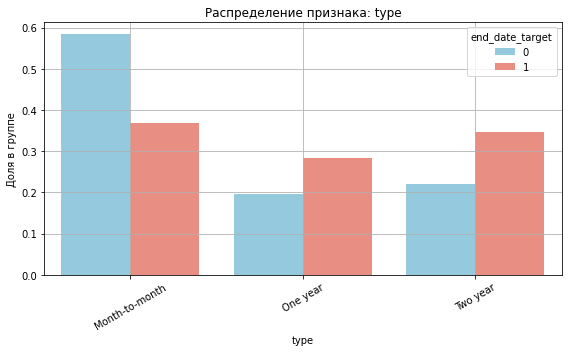

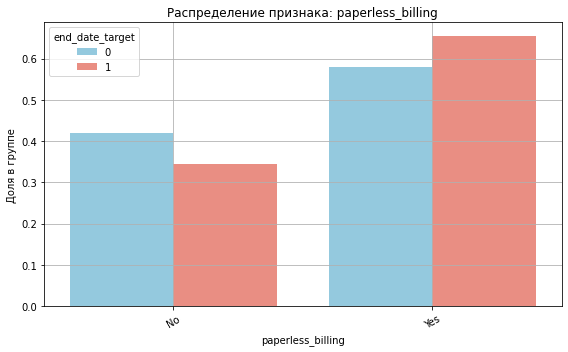

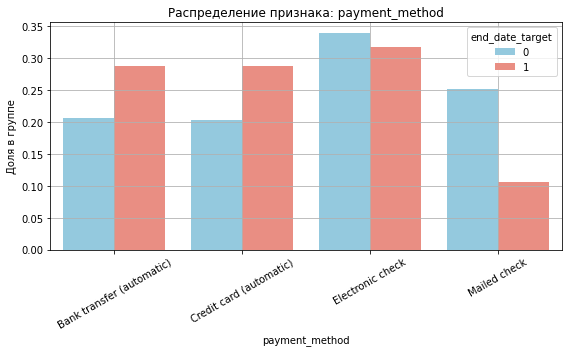

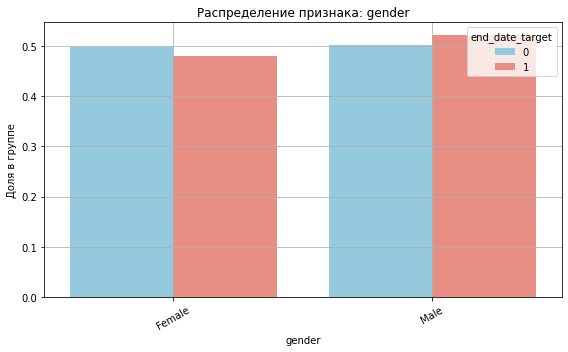

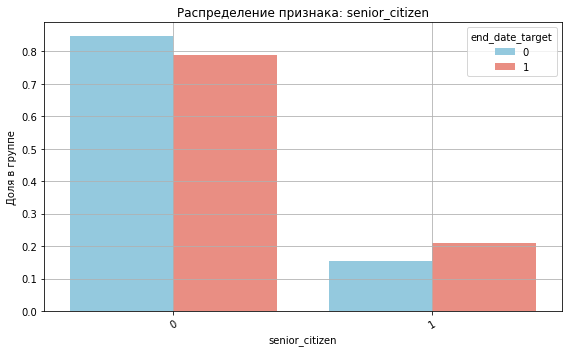

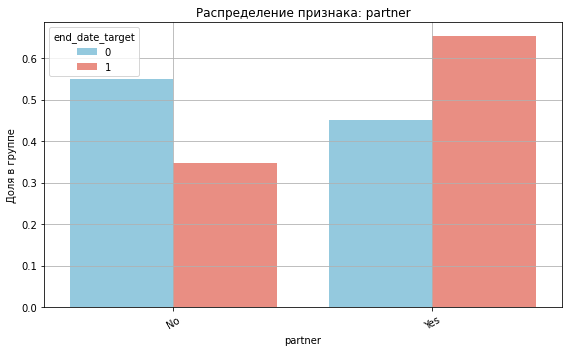

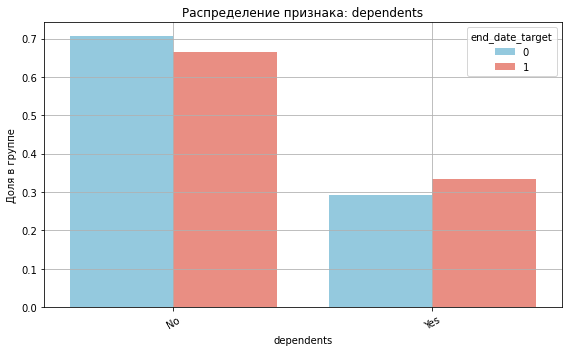

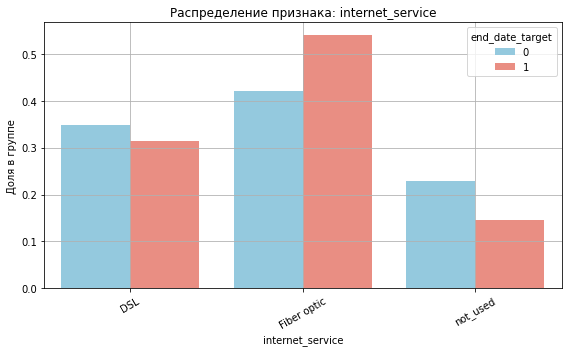

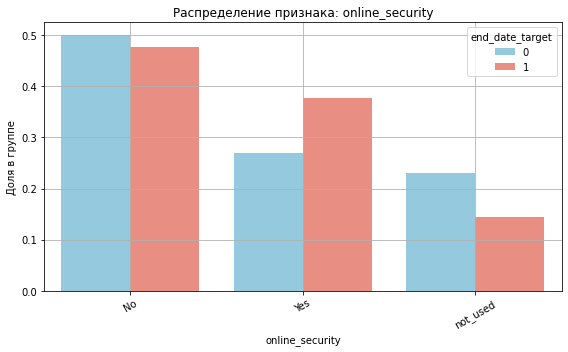

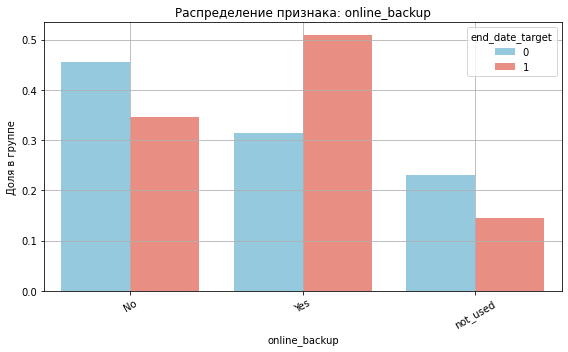

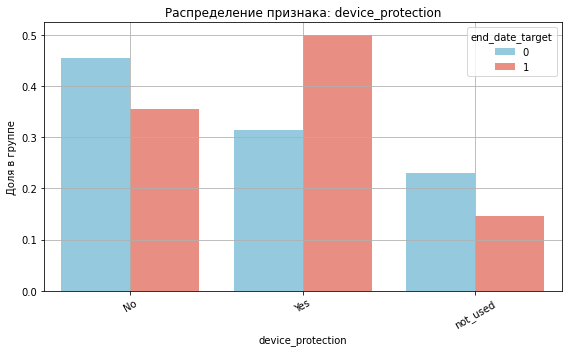

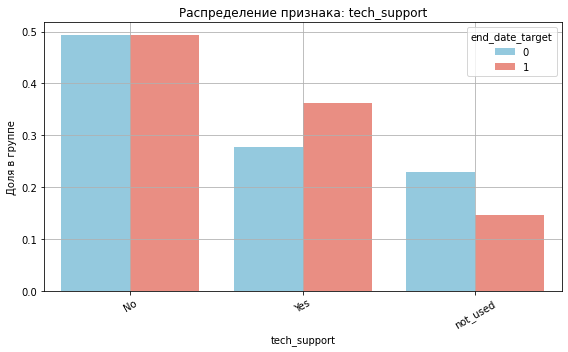

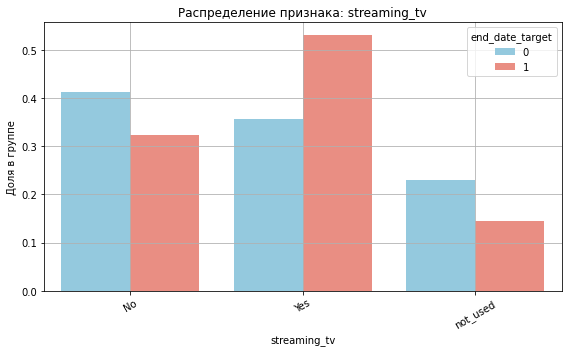

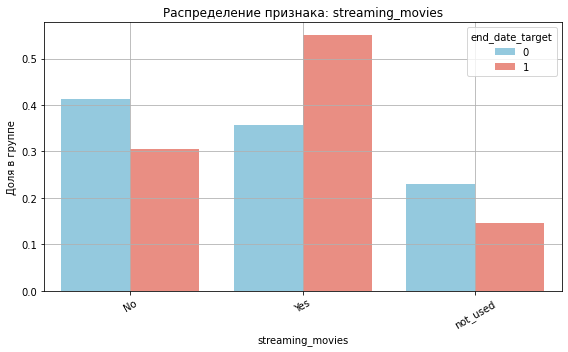

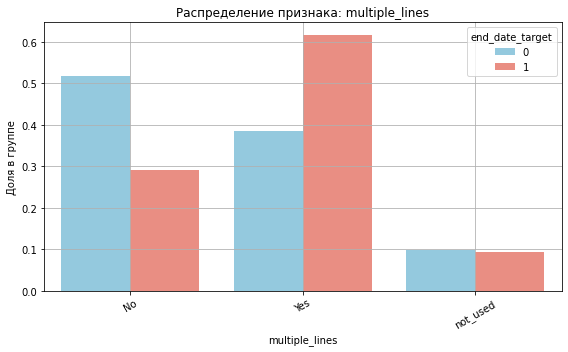

In [55]:
# применим метод к списку
barplot_cat_features(df_full, cat_features)

**Пользователи, которые завершили контракт**:
- Условия договора: ушедшие пользователи чаще заключали долгосрочные контракты на год или два, немного чаще пользовались электронными чеками, чаще оплачивали банковской картой или переводом.
- Персональные данные: примерно одинаковые распределения по полу клиентов, пенсионный статус тоже схожий, чаще встречаются пользователи с партнёром, наличие детей одинаково в обоих группах.
- Услуги: больше пользователей используют оптоволокно, чуть больше пользуются блокировкой, немного чаще используют облачные бэкапы, антивирус, тех.поддержку. и дополнительные телефонные линии. Пользователи также чаще используют услуги видео и стриминга.

### Портрет пользователя завершившего контракт

По итогам сравнения двух основных групп пользователей **пользователи, которые завершили контракт:**

- В среднем пользовались услугами 915 дней, большая плотность пользователей от 500 до 1200 дней. Чаще контракты были заключены в 2014 -2016 годах.
- Средний месячный платеж - 84, а суммарный - 2140. 
- Чаще пользовались дополнительными интернет-услугами и видео-контентом, поэтому ежемесячные и суммарные платежи у них были больше, чем у активных. 
- Также они чаще заключали долгосрочные контракты на год или два, чаще оплачивали картой или переводами. 
- Что касается персональных данных чуть больший процент пользователей находился в официальнои браке.
- Ушедших пользователей больше всего в сегменте клиентов со средними расходами (от 1000 до 4000).

### Матрица корреляций

- Построим матрицу корреляций методом Phik, так как он учитывает и числовые и категориальные признаки.
- Исключим из матрицы id, даты договоров, сегемнты пользоваталей (коррелируют суммарным платежом).
- Признаки 'begin_month', 'begin_year' тоже сильно коррелируют с длительностью контрактов, поэтому исключим их из матрицы, чтобы легче было в ней ориентироваться.
- Числовые признаки добавим в interval_cols.

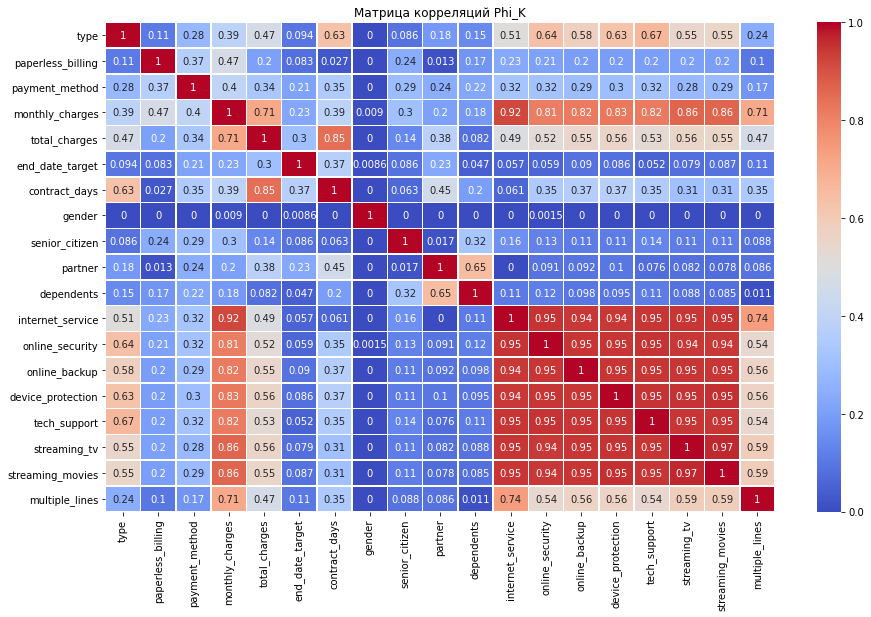

In [56]:
# построим матрицу корреляций phik для признаков
phik_matrix = df_full.drop(columns=['customer_id', 'begin_date', 'end_date', 'spending_group', 'begin_month', 'begin_year']).phik_matrix(interval_cols =['monthly_charges', 'total_charges','contract_days'])
plt.figure(figsize=(15,9))
sns.heatmap(phik_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Матрица корреляций Phi_K')
plt.show()

**Целевой признак**:
- Больше всего с целевым признаком ('end_date_target') коррелирует длительность контракта, но корреляция средняя 0.37. Чуть слабее корреляция с суммарным платежом 0.3, также присутствуют корреляции с ежемесячным платежом, способом оплаты и наличием партнёра (0.21 - 0.23).

**Остальные признаки**: 
- С **ежемесячным платежом** сильно коррелирует тип подключения - скорее всего один из типов подключения (оптоволокно) значительно дороже, остальные интернет-услуги и телефония тоже имеют сильную корреляцию, так как от их наличия зависит стоимость тарифа. Заметна корреляция и с общим платежом.
- С **суммарным платежом** сильнее всего коррелирует длительность контракта, что логично, чем дольше клиент пользуется услугами, тем больше сумма у него копится. Средняя корреляция также со всеми интернет-услугами и типом оплаты.
- Все интернет-услуги сильно коррелируют между собой так как скорее всего идут пакетом, и заметно коррелируют с типом подключения и оплаты. Пока мы не будем исключать признаки услуг из модели так как корреляция сильная, но они могут сработать хорошо в группе с другими признаками.
- Из матрицы уже **были исключены** даты начала и окончания контрактов, вместо них будем использовать длительность контракта. Год старта контракта сильно коррелирует с длительностью, месяц контракта кажется неинформативным признаком. Сегменты пользователей изначально выведены из общей суммы платежей, тоже кажутся лишними.
- Нулевая корреляция почти со всеми признаками у признака gender, исключим его из финального набора признаков.

### Выводы по разделу:
- Мы объединили все датасеты в один на основе id пользователей, датасеты имели разную размерность по этому на месте интернет-услуг у части пользователей появились пропуски. Пропуски мы заполнили отдельной категорией not_used.
- Разделили общий датафрейм на две группы пользователей: активных и завершивших контракт. Построили графики и диаграммы для сравнения признаков для двух групп пользователей.
- Завершившие контракт пользователи чаще всего заключали контракт в 2014 году. Далее по графику плавные спад по ушедшим пользователям. Пик активных пользователей в был 2019 году.
- Длительность конрактов: активные пользователи в основном сконцентрированы в началае диаграммы, то есть контракт не превышает 200 дней - это новые пользователи, подъем которых мы наблюдали с 2019 года. Также пик активных пользователей есть на отметке более 2000 дней, то есть максимум по нашим данным - пользователи, которые пришли в самом начале и до сих пор пользуются услугами. Ушедшие пользователи - пики примерно по 500 и 1000 дней, после 1000 дней идёт спад. У активных пользователей более широкий разброс длительности контрактов. Медиана у завершивших чуть выше, но распределение менее растянуто, чем у активных.
- Ежемесячный платёж: Активные пользователи - явно выраженный пик 20–25 - самый базовый тариф, далее значения плотности снижаются, небольшой пик на 70, больше 100 платят немного пользователей. Завершившие контракт - в два раза меньше пользователей с минимальными платежами, пик плотности на 100, Значительно больше пользователей с высокими ежемесячными платежами более 100. Активные пользователи: медиана около 70, межквартильный размах, завершившие контракт: медиана выше - около 90.
- **Высокие ежемесячные платежи чаще связаны с оттоком пользователей**. Возможно им не требуются все услуги за которые они платят, то есть некорректно подобраный для них тариф. Эта категория пользователей важна, поэтому необходимо чаще проверять пользуются ли они всеми услугами, напоминать о преимуществах их тарифов, уведомлять об альтернативных тарифах.
- Суммарный платёж: активные пользователи - пик плотности от 0 до 500, похоже на клиентов, которые недавно подключились. Плотность резко спадает после 1000, низкие значения после 2000. Хвост распределения длинный, но низкий: немного пользователей с суммой выше 4000. Завершившие контракт: плотность равномерно распределени 0 10 до 4000 с плавным небольшим спадом. Постепенный спад после 4000, но плотность остаётся выше, чем у активных. Активные - медиана около 1000, нижняя граница межквартильного размаха ближе к нулю. Много выбросов более 7000. Завершившие контракт: медиана 2000, нижняя граница межквартильного размаха выше, чем у активных, а верхняя почти совпадает. Выбросов меньше, они не превышают 8000. 
- У активных пользователей **общая сумма платежей** значительно ниже, так как многие подключились недавно и пользуются базовым тарифом. Ушедшие пользователи чаще имеют средний или высокий общий платёж и они уходят после длительного периода использования. Этот признак тоже связан с оттоком.
- Наибольшая доля клиентов, завершивших контракт среди среднего (от 1000 до 4000) сегмента по сумме расходов. Меньше всего клиентов завершивших контракт среди группы с низкими расходами (до 1000).
- Построили диаграммы и сравнили категориальные признаки, на основе всех признаков составили портрет пользователя, который завершил контракт.
- **Пользователи, которые завершили контракт:** в среднем пользовались услугами 915 дней, большая плотность пользователей от 500 до 1200 дней. Чаще контракты были заключены в 2014 -2016 годах. Средний месячный платеж - 84, а суммарный - 2140. Чаще пользовались дополнительными интернет-услугами и видео-контентом, поэтому ежемесячные и суммарные платежи у них были больше, чем у активных. Также они чаще заключали долгосрочные контракты на год или два, чаще оплачивали картой или переводами. Что касается персональных данных чуть больший процент пользователей находился в официальнои браке. Ушедших пользователей больше всего в сегменте клиентов со средними расходами (от 1000 до 4000).
- Построили **матрицу корреляци Phik** для всег признаков и числовых и категориальных. Больше всего с **целевым признаком** ('end_date_target') коррелирует длительность контракта, но корреляция средняя 0.37. Чуть слабее корреляция с суммарным платежом 0.3, также присутствуют корреляции с ежемесячным платежом, способом оплаты и наличием партнёра (0.21 - 0.23). С **ежемесячным платежом** сильно коррелирует тип подключения - скорее всего один из типов подключения значительно дороже, остальные интернет-услуги и телефония тоже имеют сильную корреляцию, так как от их наличия зависит стоимость тарифа. Заметна корреляция и с общим платежом. С **суммарным платежом** сильнее всего коррелирует длительность контракта, что логично, чем дольше клиент пользуется услугами, тем больше сумма у него копится. Средняя корреляция также со всеми интернет-услугами и типом оплаты. Все интернет-услуги сильно коррелируют между собой так как скорее всего идут пакетом, и заметно коррелируют с типом подключения и оплаты. Пока мы не будем исключать признаки услуг из модели так как корреляция сильная, но они могут сработать хорошо в группе с другими признаками. Из матрицы уже **были исключены** даты начала и окончания контрактов, вместо них будем использовать длительность контракта. Год старта контракта сильно коррелирует с длительностью, месяц контракта кажется неинформативным признаком. Сегменты пользователей изначально выведены из общей суммы платежей, тоже кажутся лишними.

## Обучение моделей

- Подготовим выборки.
- Подготовим пайпланы для обработки признаков и обучения моделей.
- Подберем гиперпараметры и обучим модели.
- Получим метрики ROC-AUC на кросс-валидации и сравним, чтобы выбрать подходящую модель. Критерий успеха: ROC-AUC ≥ 0.85.

Так как нам надо предсказать уйдет клиент или нет, то будем использовать модели бинарной классификации:
- LogisticRegression- простая и быстрая линейная модель для предсказания классов.
- KNeighborsClassifier - модель предсказывает на основе класса ближайших 'соседей'.
- DecisionTreeClassifier - модель, которая использует дерево решений для задач классификации.
- RandomForestClassifier - состоит из множества решающих деревьев.
- CatBoostClassifier - градиентный бустинг на деревьях, специально адаптирован для категориальных признаков, не требует энкодеров для категорий.
- LGBMClassifier- быстрый и эффективный градиентный бустинг на деревьях.

- Для подбора гиперпараметров будем использовать **GridSearchCV** - он переберет все варианты гиперпараметров и подберёт лучшую модель. Данных не очень много, поэтому поиск не должен быть долгим. 

### Подготовка данных

In [57]:
# подготовим финальный датасет
df_final = df_full.drop(columns=['customer_id', 'begin_date', 'end_date', 'spending_group', 'gender', 'begin_year', 'begin_month'])
df_final.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'end_date_target', 'contract_days', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines'],
      dtype='object')

In [58]:
# проверим дубликаты после удаления некоторых признаков
df_final.duplicated().sum()

12

In [59]:
# удалим дубликаты
df_final = df_final.drop_duplicates()
df_final.duplicated().sum()

0

In [60]:
# подготовим выборки и выделим целевой признак

X = df_final.drop(columns=['end_date_target'])
y = df_final['end_date_target']

In [61]:
# зафиксируем random_state
RANDOM_STATE = 140725

# разделим данные на выборки, используем стратификацию из-за дисбаланса классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# проверим размерности
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5273, 17), (1758, 17), (5273,), (1758,))

- Создадим несколько пайплайнов по обработке признаков, чтобы учитывать особенности моделей.
- В основном будем использвать OneHotEncoder для категориальных признаков, так как он подходит и для неупорядоченных категорий и для бинарных признаков.
- Для числовых признаков попробуем использовать несколько скейлеров и вариант без обработки.

In [62]:
# создаём списки признаков для обработки

cat_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines' ]
num_features = ['monthly_charges','total_charges', 'contract_days']

In [63]:
# создаём пайплайн для обработки признаков из списка ohe_columns: заполняем пропуски, используем OneHotEncoder
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [64]:
# инициализируем StandardScaler для количественных признаков и OHE для категориальных признаков

num_transformer = StandardScaler()
cat_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

Напишем метод для получения метрики ROC-AUC модели, также будем сохранять метрику в список, чтобы потом сделать наглядную таблицу для сравнения.

In [65]:
# создадим таблицу результатов
results = []

# метод для оценки модели
def evaluate_grid_search(grid_search, model_name='Модель'):
    
    # выберем лучшую модель, получим результаты на кросс валидации
    best_idx = grid_search.best_index_
    roc_auc = grid_search.best_score_
    best_params = grid_search.best_params_

    # покажем результаты
    print(f'{model_name}:')
    print(f'ROC-AUC на кросс-валидации: {roc_auc:.3f}')
    print(f'Параметры лучшей модели: {best_params}')
    
    # вернем результаты
    return {
        'model': model_name,
        'roc_auc': roc_auc
    }

### Логистическая регрессия
Подберем гиперпараметры: 
- model__penalty - тип регуляризации ('l1' Lasso -спарсивает веса, отбрасывает слабые признаки, 'l2' Ridge - сглаживает веса, но не зануляет их.)
- model__C - обратный коэффициент регуляризации (чем меньше C, тем модель проще).
- model__solver - алгоритм оптимизации.
- Будем использовать два скейлера для данных StandardScaler(), MinMaxScaler() и вариант без обработки.

In [66]:
# подготовим препроцессор для линейной модели
preprocessor_lr = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_ohe, cat_features)
])

# подготовим итоговый пайплайн для логистической регрессии
pipeline_lr = Pipeline([
    ('preprocess', preprocessor_lr),
    ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])



In [67]:
# создадим сетку гиперпараметров
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear', 'saga'],
    'preprocess__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

In [68]:
# используем GridSearch с кросс-валидацией, ищем лучшую модель на основе метрики ROC-AUC
lr_grid = GridSearchCV(
    pipeline_lr,
    param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# обучаем модель
lr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',...
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=140725))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga'],
                         'preprocess__num': [StandardScaler(), MinMaxScaler(),
                                             'passthrough']},
             scoring='roc_auc', verbose=1)

In [69]:
# применим метод и получим результаты
lr_result = evaluate_grid_search(lr_grid, model_name='LogisticRegression')

# добавим результаты в список
results.append(lr_result)

LogisticRegression:
ROC-AUC на кросс-валидации: 0.773
Параметры лучшей модели: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'saga', 'preprocess__num': StandardScaler()}


### KNeighborsClassifier

Подберем гиперпараметры:
- n_neighbors - количество соседей.
- weights взвешивание соседей ('uniform' — все соседи равны, 'distance' — ближние соседи важнее).
- p - подсчёт расстояния (1 - манхэттенское расстояние, 2 - евклидово расстояние).
- Будем использовать StandardScaler для числовых признаков, так как KNN чувствительная к масштабу модель

In [70]:
# подготовим обработку признаков
preprocessor_knn = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
])

In [71]:
# соберем итоговый пайплайн для knn
pipeline_knn = Pipeline([
    ('preprocess', preprocessor_knn),
    ('model', KNeighborsClassifier())
])

In [72]:
# сеть гиперпараметров
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 10],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

# подготовим поиск
knn_grid = GridSearchCV(
    pipeline_knn,
    param_grid_knn,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# обучим модель
knn_grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [3, 5, 7, 10],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [73]:
# применим метод и получим результаты
knn_result = evaluate_grid_search(knn_grid, model_name='KNeighborsClassifier')

# добавим результаты в список
results.append(knn_result)

KNeighborsClassifier:
ROC-AUC на кросс-валидации: 0.780
Параметры лучшей модели: {'model__n_neighbors': 10, 'model__p': 2, 'model__weights': 'uniform'}


### DesicionTreeClassifier

Подберем гиперпараметры:
- max_depth - максимальная глубина дерева, ограничивает глубину, предотвращая переобучение.
- min_samples_split — минимальное число образцов для разбиения узла.
- min_samples_leaf — минимальное число объектов в листе.
- DecisionTree не требует скейлинга для числовых признаков, но надо использовать OneHotEncoder для категорий.

In [74]:
# подготовим обработку признаков
preprocessor_tree = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
])

# итоговый пайплайн
pipeline_tree = Pipeline([
    ('preprocess', preprocessor_tree),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_tree = {
    'model__max_depth': [3, 5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [75]:
# поиск гиперпараметров
grid_tree = GridSearchCV(
    pipeline_tree,
    param_grid_tree,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# обучаем модель
grid_tree.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=140725))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='roc_auc', verbose=1)

In [76]:
# получим результаты
tree_result = evaluate_grid_search(grid_tree, model_name='DesicionTreeClassifier')

# добавим результаты в список
results.append(tree_result)

DesicionTreeClassifier:
ROC-AUC на кросс-валидации: 0.786
Параметры лучшей модели: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


### RandomForestClassifier
Подберем гиперпараметры:
- n_estimators — количество деревьев в лесу, чем больше деревьев, тем стабильнее и точнее модель, но они увеличивают время обучения и требуют ресурсов.
- Остальные параметры схожи с DecisionTree.
- Модель тоже не требует скейлинга для числовых признаков.

In [77]:
# подготовим обработку признаков
preprocessor_rf = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
])

# пайплайн
pipeline_rf = Pipeline([
    ('preprocess', preprocessor_rf),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

# гиперпараметры
param_grid_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

In [78]:
# подготовим сеть
rf_grid = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# обучим модель
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',
                                                                          'on...
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=140725))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5, 10],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200, 500]},
             scoring='roc_auc', verbose=1)

In [79]:
# получим результаты
rf_result = evaluate_grid_search(rf_grid, model_name='RandomForestClassifier')

# добавим результаты в список
results.append(rf_result)

RandomForestClassifier:
ROC-AUC на кросс-валидации: 0.827
Параметры лучшей модели: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500}


### CatBoostClassifier

Подберем гиперпараметры:
- depth — глубина деревье, чем больше глубина тем лучше модель, но выше риск переобучения.
- learning_rate — скорость обучения, чем медленне обучается, тем лучше качество.
- iterations — количество деревьев (итераций бустинга).
- Все числовые признаки включаются в модель без преобразований, поэтому не будем использовать скейлеры. Категориальные признаки приведем к строкам.


In [80]:
# так как CatBoost может работать с категориальными признаками напрямую, преобразуем все признаки в строки
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [81]:
# подготовим пайплайн
pipeline_cat = Pipeline([
    ('model', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        cat_features=cat_features
    ))
])

# гиперпараметры
param_grid_cat = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.1],
    'model__iterations': [100, 300, 500],
}

# поиск по гиперпараметрам
grid_cat = GridSearchCV(
    pipeline_cat,
    param_grid_cat,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# обучаем модель
grid_cat.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x7f46f60500a0>)]),
             n_jobs=-1,
             param_grid={'model__depth': [4, 6, 8],
                         'model__iterations': [100, 300, 500],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='roc_auc', verbose=1)

In [82]:
# получим результаты
cat_result = evaluate_grid_search(grid_cat, model_name=' CatBoostClassifier')

# добавим результаты в список
results.append(cat_result)

 CatBoostClassifier:
ROC-AUC на кросс-валидации: 0.879
Параметры лучшей модели: {'model__depth': 6, 'model__iterations': 500, 'model__learning_rate': 0.1}


### LGBMClassifier

Подберем гиперпараметры:
- n_estimators - количество деревьев (итераций бустинга).
- max_depth — максимальная глубина дерева.
- learning_rate — скорость обучения.
- num_leaves — максимальное количество листьев в дереве.
- LightGBM может напрямую работать с категориальными признаками, но в Pipeline удобнее использовать OneHotEncoder.


In [83]:
# подготовим обработку признаков
preprocessor_lgb = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_features)
])

# пайплайн
pipeline_lgb = Pipeline([
    ('preprocess', preprocessor_lgb),
    ('model', LGBMClassifier(
        objective='binary',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# гиперпараметры
param_grid_lgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, -1],  # -1 = без ограничения
    'model__learning_rate': [0.01, 0.1],
    'model__num_leaves': [15, 31, 63]
}

In [84]:
# поиск по гиперпараметрам
grid_lgb = GridSearchCV(
    pipeline_lgb,
    param_grid=param_grid_lgb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# обучим модель
grid_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'contract_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'internet_service',...
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LGBMClassifier(objective='binary',
                                                       random_state=140725))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 6, -1],
                         'model__n_estimators': [100, 200],
                         'model__num_leaves': [15, 31, 63]},
             scoring='roc_auc', verbose=1)

In [85]:
# получим результаты
lgb_result = evaluate_grid_search(grid_lgb, model_name='LGBMClassifier')

# добавим результаты в список 
results.append(lgb_result)

LGBMClassifier:
ROC-AUC на кросс-валидации: 0.867
Параметры лучшей модели: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__num_leaves': 15}


### Cравним модели

In [86]:
# посмотрим результаты
# преобразуем список в датафрейм отсортируем по метрике
results_df = pd.DataFrame(results)
results_df = results_df.set_index('model')
results_df = results_df.sort_values('roc_auc', ascending=False)
results_df

,roc_auc
model,
CatBoostClassifier,0.878713
LGBMClassifier,0.867424
RandomForestClassifier,0.827132
DesicionTreeClassifier,0.786103
KNeighborsClassifier,0.780025
LogisticRegression,0.773261


Выберем CatBoostClassifier так как у него самый высокий ROC-AUC, проверим на тестовой модели. 

In [87]:
# посчитаем ROC-AUC для тестовой выборки

y_pred = grid_cat.predict(X_test)

y_pred_proba = grid_cat.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC на тестовой выборке: {roc_auc:.4f}")

ROC-AUC на тестовой выборке: 0.9104


 ### Выводы по разделу:
 - Мы подготовили данные для обучения модели: разделили данные на выборки, выделили целевой признак. 
 - Подготовили пайпллайны для обучения нескольких моделей: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier.
 - Подготовили пайплайны для обработки признаков наиболее подходящие для каждой модели, подобрали гиперпараметры.
 - Получили метрику ROC-AUC на кросс-валидации для всех моделей и сравнили метрики. 
 - Выбрали **модель с самой высокой ROC-AUC: CatBoostClassifier** - ROC-AUC на кросс-валидации: 0.878, на тестовой - 0.91.

## Проверка качества модели
- Получим основные метрики модели.
- Сравним с Dummy моделью. 
- Построим ROC-кривую и распределение вероятностей модели.
- Построим матрицу ошибок.
- Проверим важность признаков.

### Метрики модели и предсказания

In [88]:
# посчитаем основные метрики
print('Accuracy:', round(accuracy_score(y_test, y_pred), 2))
print('Precision:', round(precision_score(y_test, y_pred), 2))
print('Recall:', round(recall_score(y_test, y_pred), 2))
print('F1-score:', round(f1_score(y_test, y_pred), 2))

Accuracy: 0.91
Precision: 0.82
Recall: 0.54
F1-score: 0.65


- **Accuracy:** - высокое значение, модель правильно классифицирует 91% объектов.
- **Precision** - высокая метрика, из всех объектов, предсказанных как положительные, 82% действительно положительные.
- **Recall** - низкий показатель, из всех настоящих положительных случаев модель находит только 54%.
- **F1-score** - средний результат, скорее из-зи низкого recall.


- Модель хорошо классифицирует объектв положительного класса, но может и пропустить такие объекты. То есть модель подходит для предсказания того, что пользователь уйдёт, но может пропустить часть таких клиентов. Это не очень подходит под условия заказчика. 
- Несмотря на высокое значение accuracy, модель пропускает часть пользователей, готовых завершить контракт. Чтобы улучшить предсказания по таким клиентам, мы можем **сместить порог классификации**. Это повысит recall и позволит находить больше потенциально готовящихся уйти пользователей, но с увеличением количества ложных предсказаний. Для бизнеса это будет выгоднее, так как важнее не упустить тех, кто действительно может уйти.



Проверим dummy-модель, чтобы убедиться, что качество предсказаний лучшей модели выше случайного.

In [89]:
# обучаем dummy-модель
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

# получаем предсказания
y_pred_dummy = dummy.predict(X_test)

# посчитает метрику ROC-AUC
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print(f'ROC-AUC лучшей модели: {roc_auc:.2f}')
print(f'ROC-AUC dummy: {roc_auc_dummy:.2f}')

ROC-AUC лучшей модели: 0.91
ROC-AUC dummy: 0.50


- ROC-AUC основной модели cущественно выше, чем у DummyClassifier - основная модель уверенно классифицирует клиентов и делает это гораздо лучше, чем случайная классификация.

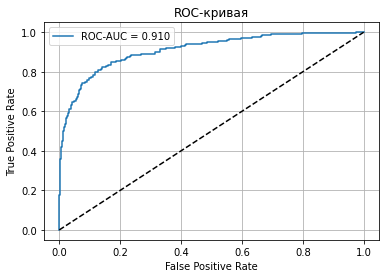

In [90]:
# построим ROC-кривую для визуализации предсказаний
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

- Модель уверенно классифицирует клиентов, качество предсказаний высокое.
- Кривая далеко от диагонали - то есть она точно лучше случайного угадывания.

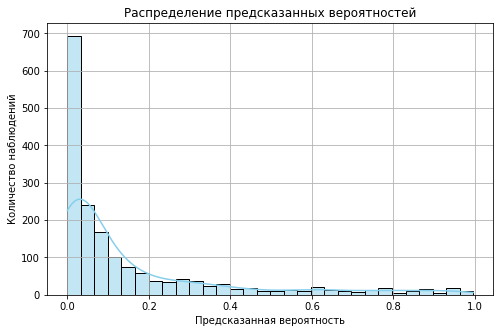

In [91]:
# посмотрим на распределение вероятностей модели
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba, bins=30, kde=True, color='skyblue')
plt.title('Распределение предсказанных вероятностей')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Количество наблюдений')
plt.grid(True)
plt.show()

- Около 600 наблюдений получили предсказанную вероятность близкую к 0, то есть модель уверена, что большинство клиентов не уйдут.
- Только небольшая часть объектов получает высокие вероятности оттока, то есть мало объектов класса 1.
- По этому графику видим, что базовый порог 0.5 может быть неэффективным, так как большинство предсказаний оттока будут пропущены.

### Матрица ошибок

<Figure size 432x432 with 0 Axes>

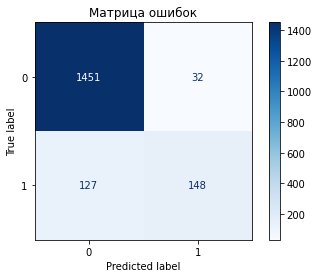

In [92]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_cat.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Матрица ошибок")
plt.grid(False)
plt.show()

- True Negative  - модель хорошо определяет активных клиентов, не готовых уйти
- False Positive - мало ложно-положительных объектов
- False Negative - много пропущенных клиентов, которые собираются уйти
- True Positive - точно предсказывает клиентов, которые действительно уйдут

По матрице видим похожее предположение: модель почти не делает ложных предсказаний, но пропускает значительную часть реальных оттока.





Попробуем подобрать порог, который увеличит вероятность предсказания оттока, но не сильно уменьшит precision, то есть будет баланс.

In [93]:
best_threshold = 0
best_recall = 0
best_precision = 0

# определим минимальный precision
min_precision = 0.5

thresholds = np.arange(0.01, 0.99, 0.01)

# посчитаем порог
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    if recall > best_recall and precision >= min_precision:
        best_recall = recall
        best_threshold = t
        best_precision = precision
        y_pred_custom = y_pred  # сохраним предсказания для лучшего порога
        best_accuracy = accuracy

# вывод результатов
print(f'Лучший порог: {best_threshold:.2f}')
print(f'Recall: {best_recall:.2f}')
print(f'Precision: {best_precision:.2f}')
print(f'F1-score: {f1_score(y_test, y_pred_custom):.2f}')
print(f'Accuracy: {best_accuracy:.2f}')

Лучший порог: 0.19
Recall: 0.82
Precision: 0.51
F1-score: 0.63
Accuracy: 0.85


<Figure size 432x432 with 0 Axes>

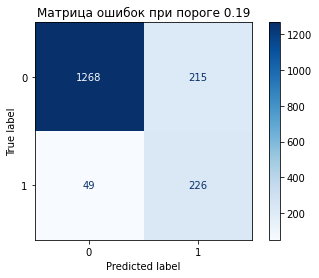

In [94]:
# построим новую матрицу ошибок с учетом порога
y_pred_custom = (y_pred_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_custom)

# посмотрим на матрицу
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Матрица ошибок при пороге {best_threshold:.2f}')
plt.grid(False)
plt.show()

- При дальнейшем снижении порога точность модели будет падать ещё больше, можно остановиться на пороге 0.2, так мы минимизируем риск пропустить уходящего клиента, но увеличим риск сфокусироваться на клиентах, которые не планирую уходить.

### Важность признаков

In [95]:
# проверим важность признаков
# достанем лучшую модель из пайплайна
best_model = grid_cat.best_estimator_
cat_model = best_model.named_steps['model']

In [96]:
# определим названия признаков
feature_names = X_train.columns
feature_names

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'contract_days', 'senior_citizen', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

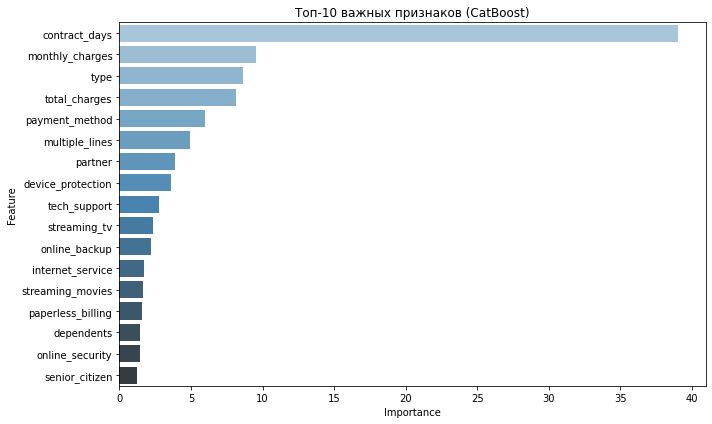

In [97]:
importances = cat_model.get_feature_importance()
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='Blues_d')
plt.title('Топ-10 важных признаков (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

- Видим на диаграмме, что самым важным признаком для классификации является количество дней контракта, он намного важнее остальных признаков.
- Также важны ежемесячные расходы, тип оплаты, общие расходы, способ оплаты, наличие антивируса и дополнительных линий, наличие партнёра. 
- В меньшей степени на модель влияют пенсионный возраст, видео-услуги, наличие детей, электронный расчёт и тип подключения.

### Выводы по разделу:
- Получили и проанализировали метрики модели. Сравнили предсказания с Dummy-моделью: метрики CatBoost намного выше, чем у Dummy-модели. Построили ROC-кривую для визуализации предсказаний и распределение вероятностей модели. Построили матрицу ошибок - модель уверенно определяет клиентов, которые останутся, но пропускает много клиентов, которые могут уйти. 
- Мы уменьшили порог классификации, чтобы модель реже пропускала готовящихся уйти клиентов, но это уменьшает её точность. Необходимо обсудить с заказчиком дальнейшее изменение порога, так как увеличивается число клиентов, которым следует предлагать специальные условия, хотя риск того, что они уйдут минимальный.
- Проанализировали важность признаков: самым важным признаком для классификации является количество дней контракта, он намного важнее остальных признаков. Также важны ежемесячные расходы, тип оплаты, общие расходы, способ оплаты, наличие антивируса и дополнительных линий, наличие партнёра. В меньшей степени на модель влияют пенсионный возраст, видео-услуги, наличие детей, электронный расчёт и тип подключения.

## Итоговый вывод:

**Цель исследования:** Обучить модель, которая предскажет, кто из клиентов собираются завершить контракт.

**В ходе первого исследования** мы:
- Загрузили четыре датафрейма с данными о клиентах, в датасетах содержится информация о клиентах, типах подключения, услугах и оплате. Все заявленые данные в датасетах присутствуют. Пропусков и явных дубликатов в датафреймах не обнаружено.
- Проанализировали все данные в датафреймах. Изменили формат признаков 'begin_date' и 'end_date' на datetime, заменили значения 'No' в признаке 'end_date' на дату выгрузки данных. Добавили целевой признак 'end_date_target', где 0 - активные пользователи, 1 - пользователи, которые завершили контракт.  Заменили формат числового признака 'total_charges', после смены формата обнаружили 11 пропусков у новых пользователей, которые заменили на значение месячного платежа этих пользователей.
- Посчитали соотношение активных пользователей и пользователей, которые завершили контракт: 84 - активные, 16% - завершили контракт. Есть дисбаланс классов целевого признака, поэтому будем использовать стратификацию при подготовке данных для модели.
- Построили временные графики для отслеживания периода старта контрактов: пик в начале графика в 2014 году, скорее всего большинство существующих контрактов было внесено в данные в этот период, либо в этот период стартовала работа сервиса. Далее данные распределены равномерно до 2018 года, с 2018 года наблюдается плавный рост. Пик роста приходится на конец 2019 года, количество контрактов достигает примерно 250 в месяц.
- Построили график по оттоку клиентов: отток клиентов растет с 2015 по 2020, количество завершённых контрактов постепенно увеличивается почти каждый год. Рост может быть связан с ростом количества клиентов. Пик почти в конце 2019 года, он может быть связан с изменениями в тарифах или услугах. Регулярная сезонность отсутствует, нет чётких спадов или подъёмов по сезонам.
- Сравнили старт контрактов и отток клиентов: с 2014 года отток клиентов растёт, но сильно отстаёт от заключения новых контрактов. Ближе к 2020 разница между новыми и завершёнными контрактами уменьшается.
- Добавили новый признак - длительность контракта в днях. Построили распределение: пик на отметке около 200 дней - здесь могут быть, как новые клиенты, рост, которых наблюдается в последние месяцы, так и клиенты, которые отказались от услуг в первые месяцы использования. Значительная часть контрактов не превышает 1200 дней. Пик в конце графика (примерно 2200 дней) - долгоживущие клиенты.
- **Ежемесячные расходы** варьируются от 20 до 120. Пик в начале гистограммы - большая часть клиентов пользуется самы базовым тарифом с минимальной ежемесячной оплатой. Следующий пик на значении 80 - тоже популярный ежемесячный тариф. Медиана примерно 70, межквартильный размах - от 35 до 90, минимальные и максимальные значения от 20 до 120, выбросов нет.
- **Суммарные расходы** - распределение сильно асимметрично, основная масса пользователей суммарно заплатила до 2000. Резкий пик на минимальных суммах ниже 500. Возможно, это новые клиенты с минимальными тарифами, либо клиенты, которые быстро перестали пользоваться услугами. Медиана примерно 1500, межквартильный размах - от 700 до 2500. Множество выбросов - зто клиенты, которые суммарно заплатили больше 7500.
- Категориалиные признаки: **Тип подключения** - всего три типа подключения: 55% клиентов подключены с ежемесячной оплатой, 24% клиентов оплатили два года, 21% - один год. **Электронный расчётный лист** - 59% пользователей имеют электронный расчётный лист, 41% - не имеют. **Тип платежа** - 34% клиентов оплачивают услуги по электронному чеку (онлайн платёж), 23% с отправкой чека обычной почтой, 22% через банковский перевод, 22% авто-платежи банковской картой.
- **Персональные данные клиентов** - **Пол**: распределение примрно по 50%. **Сведения о пенсионном статусе** - 16% пользователей являются пенсионерами, 84% - не являются. **Партнёр** - 48% клиентов имеют супруга/супругу, 52% - не имеют. **Дети** - у 30% клиентов есть дети, у - 70% детей нет.
- **Интернет подключение и телефония** - **тип подключения** - 56% клиентов использут оптоволокно, 44% DSL. **Блокировка опасных сайтов** -63% не использут, 37% используют блокировку. **Облачное хранилище** - 56% не используют, 44% используют. **Антивирус** - 56% не используют антивирус, 44% используют. **Выделенная линия тех.поддержки** - 63% клиентов не используют, 37 используют. **Стриминговое телевидение и фильмы** - половина клиентов использует сервисы видео. - **Дополнительный телефонные линии** - 53% клиентов не используют, 47 используют.
- Каких либо отклонений в данных, дополнительных категорий или аномалий не обнаружено.



- Объединили все датасеты в один на основе id пользователей, датасеты имели разную размерность по этому на месте интернет-услуг у части пользователей появились пропуски. Пропуски мы заполнили отдельной категорией not_used.
- Разделили общий датафрейм на две группы пользователей: активных и завершивших контракт. Построили графики и диаграммы для сравнения признаков для двух групп пользователей.
- Завершившие контракт пользователи чаще всего заключали контракт в 2014 году. Далее по графику плавные спад по ушедшим пользователям. Пик активных пользователей в был 2019 году.
- Длительность конрактов: активные пользователи в основном сконцентрированы в началае диаграммы, то есть контракт не превышает 200 дней - это новые пользователи, подъем которых мы наблюдали с 2019 года. Также пик активных пользователей есть на отметке более 2000 дней, то есть максимум по нашим данным - пользователи, которые пришли в самом начале и до сих пор пользуются услугами. Ушедшие пользователи - пики примерно по 500 и 1000 дней, после 1000 дней идёт спад. У активных пользователей более широкий разброс длительности контрактов. Медиана у завершивших чуть выше, но распределение менее растянуто, чем у активных.
- Ежемесячный платёж: Активные пользователи - явно выраженный пик 20–25 - самый базовый тариф, далее значения плотности снижаются, небольшой пик на 70, больше 100 платят немного пользователей. Завершившие контракт - в два раза меньше пользователей с минимальными платежами, пик плотности на 100, Значительно больше пользователей с высокими ежемесячными платежами более 100. Активные пользователи: медиана около 70, межквартильный размах, завершившие контракт: медиана выше - около 90.
- **Высокие ежемесячные платежи чаще связаны с оттоком пользователей**. Возможно им не требуются все услуги за которые они платят, то есть некорректно подобраный для них тариф. Эта категория пользователей важна, поэтому необходимо чаще проверять пользуются ли они всеми услугами, напоминать о преимуществах их тарифов, уведомлять об альтернативных тарифах.
- У активных пользователей **общая сумма платежей** значительно ниже, так как многие подключились недавно и пользуются базовым тарифом. Ушедшие пользователи чаще имеют средний или высокий общий платёж и они уходят после длительного периода использования. Этот признак тоже связан с оттоком.
- Наибольшая доля клиентов, завершивших контракт среди среднего (от 1000 до 4000) сегмента по сумме расходов. Меньше всего клиентов завершивших контракт среди группы с низкими расходами (до 1000).
- Построили диаграммы и сравнили категориальные признаки, на основе всех признаков составили портрет пользователя, который завершил контракт.
- **Пользователи, которые завершили контракт:** в среднем пользовались услугами 915 дней, большая плотность пользователей от 500 до 1200 дней. Чаще контракты были заключены в 2014 -2016 годах. Средний месячный платеж - 84, а суммарный - 2140. Чаще пользовались дополнительными интернет-услугами и видео-контентом, поэтому ежемесячные и суммарные платежи у них были больше, чем у активных. Также они чаще заключали долгосрочные контракты на год или два, чаще оплачивали картой или переводами. Что касается персональных данных чуть больший процент пользователей находился в официальнои браке. Ушедших пользователей больше всего в сегменте клиентов со средними расходами (от 1000 до 4000).
- Построили **матрицу корреляци Phik** для всег признаков и числовых и категориальных. Больше всего с **целевым признаком** ('end_date_target') коррелирует длительность контракта, но корреляция средняя 0.37. Чуть слабее корреляция с суммарным платежом 0.3, также присутствуют корреляции с ежемесячным платежом, способом оплаты и наличием партнёра (0.21 - 0.23). С **ежемесячным платежом** сильно коррелирует тип подключения - скорее всего один из типов подключения значительно дороже, остальные интернет-услуги и телефония тоже имеют сильную корреляцию, так как от их наличия зависит стоимость тарифа. Заметна корреляция и с общим платежом. С **суммарным платежом** сильнее всего коррелирует длительность контракта, что логично, чем дольше клиент пользуется услугами, тем больше сумма у него копится. Средняя корреляция также со всеми интернет-услугами и типом оплаты. Все интернет-услуги сильно коррелируют между собой так как скорее всего идут пакетом, и заметно коррелируют с типом подключения и оплаты. Пока мы не будем исключать признаки услуг из модели так как корреляция сильная, но они могут сработать хорошо в группе с другими признаками. Из матрицы уже **были исключены** даты начала и окончания контрактов, вместо них будем использовать длительность контракта. Год старта контракта сильно коррелирует с длительностью, месяц контракта кажется неинформативным признаком. Сегменты пользователей изначально выведены из общей суммы платежей, тоже кажутся лишними.



 - Подготовили данные для **обучения моделей**: разделили данные на выборки, выделили целевой признак. Подготовили пайпллайны для обучения нескольких моделей: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier. Подготовили пайплайны для обработки признаков наиболее подходящие для каждой модели, подобрали гиперпараметры. Получили метрику ROC-AUC на кросс-валидации для всех моделей и сравнили метрики. 
 - Выбрали **модель с самой высокой ROC-AUC: CatBoostClassifier** - ROC-AUC на кросс-валидации: 0.878, на тестовой - 0.91.
 - Получили и проанализировали метрики модели. Сравнили предсказания с Dummy-моделью: метрики CatBoost намного выше, чем у Dummy-модели. Построили ROC-кривую для визуализации предсказаний и распределение вероятностей модели. Построили матрицу ошибок - **модель уверенно определяет клиентов, которые останутся, но пропускает много клиентов, которые могут уйти**. 
 - Мы уменьшили порог классификации, чтобы модель реже пропускала готовящихся уйти клиентов, но это уменьшает её точность. Необходимо обсудить с заказчиком дальнейшее изменение порога, так как увеличивается число клиентов, которым следует предлагать специальные условия, хотя риск того, что они уйдут минимальный.
 - Проанализировали важность признаков: самым важным признаком для классификации является количество дней контракта, он намного важнее остальных признаков. Также важны ежемесячные расходы, тип оплаты, общие расходы, способ оплаты, наличие антивируса и дополнительных линий, наличие партнёра. В меньшей степени на модель влияют пенсионный возраст, видео-услуги, наличие детей, электронный расчёт и тип подключения.

**Рекомендации для бизнеса**: 
- Согласно исследованию, наиболее значимым фактором для пользователя, который собирается завершить контракт, является длительность договора, высокие ежемесячные платежи, тип оплаты на год или два. Чаще всего средняя длительность контрактов таких клиентов 915 дней, средний платёж в месяц 84, а суммарный 2140. Чаще выбирают тип оплаты на год или два, пользуются дополнительными интернет-услугами и дополнительными линиями.
- Для таких клиентов целесообразно разрабатывать альтернативные тарифные планы с возможностью отказа от лишних услуг и снижения ежемесячной нагрузки. Также можно внедрить персонализированные предложения, направленные на повышение лояльности.
- Необходимо обсудить с бизнесом целесообразность снижения порога классификации. При снижении порога увеличивается вероятность выявить больше клиентов, склонных к уходу, но одновременно растёт число ложных предсказаний. Важно найти баланс - минимизировать отток или избежать избыточных спецпредложений для клиентов, которые не собираются уходить.
